# Kaggle TGS Salt Identification Challenge - Fast.ai 0.7.x Solution

### Final Standing: 264th / 3291 teams; Private LB Score: 0.864

I'm a current fast.ai student and the U-net architecture and training regime presented in the [Carvana notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/carvana-unet.ipynb) presented in [Lesson 14](http://course.fast.ai/lessons/lesson14.html) of the 2018 edition of fast.ai's [Deep Learning Part 2](http://course.fast.ai/part2.html) course served as the foundation upon which I built my solution.

### Network architecture
* U-net with a pre-trained ResNet34 bottleneck.

### Training regime
* Adam optimizer with weight decay.
* Progressive resizing of train/val image sizes from 64x64, to 128x128, and then finally to 256x256.
* At each image size, first train top layer group with the learning rate (lr=1e-2, in my case) found using the learning rate finder learn.lr_find().
* Then unfreeze batchnorm layers and weights at all the lower layer groups, and train them using discriminative fine-tuning (previous fast.ai students will know this technique as "differential learning rates"). Gradual unfreezing and discriminative fine-tuning are both mentioned in: https://arxiv.org/pdf/1801.06146.pdf.
* One-cycle training with momentum, as introduced by Leslie Smith in: https://arxiv.org/pdf/1803.09820.pdf. Sylvain Gugger gives a great intro in https://sgugger.github.io/the-1cycle-policy.html. Since I used fast.ai 0.7.x, I was unable to make use of the [latest](http://docs.fast.ai/training#Extending-training-with-callbacks) one-cycle API found in fast.ai 1.x. I nonetheless was able to approximate it (everything but the cosine annealing) by using use_clr() with properly chosen hyperparameters. I found that use_clr() performed a bit better than use_clr_beta() for my architecture.

### Important modifications
* Images are more similar to top-down satellite imagery than the side-facing images that comprise most of imagenet, so use higher discriminative learning rates lrs = [lr/9,lr/3,lr], as opposed to the lrs = [lr/100,lr/10,lr] used in the Carvana notebook.
* The fast.ai 0.7.x default augmentations for satellite imagery **did not** work well for me. Thankfully, fellow fast.ai student [Vishnu](https://www.kaggle.com/vishnus) reported that just using simple random horizontal flips did improve performance. This turned out to be true for me as well, and Vishnu's TestFilesDataset() [class](https://github.com/svishnu88/TGS-SaltIdentification-Open-Solution-fastai/blob/master/Unet-Resnet34-Open%20Solution-FastAI.ipynb) was invaluable in my being able to use these augmentations at TTA **(+0.01 Private LB)**.
* fast.ai's learn.TTA doesn't work for this because afaik there's no way to force it to apply the same augmentation to *all* images in the test set, which is what I needed to do here to see an improvement.

### Other techniques that helped
* For each training cycle, first run the cycle using binary cross-entropy with logits as the loss function, and then run the cycle again using Lovasz Hinge loss: Lovasz Hinge Loss: https://arxiv.org/pdf/1705.08790.pdf. I used the implementation from the author's [github].(https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py).
* Adding Concurrent Spatial and Channel Squeeze & Excitation blocks to the U-net decoder **(+0.032 Private LB)**: https://arxiv.org/pdf/1803.02579.pdf. I used the [implementation](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66178) generously provided by [Bilal](https://www.kaggle.com/bkkaggle).
* Snapshot ensembling **(+0.001 Private LB)**: https://arxiv.org/pdf/1704.00109.pdf. I wrote a custom class to save and return the best N models from a single training cycle. This was inspired by the SaveBestModel() [class](http://forums.fast.ai/t/a-code-snippet-to-save-the-best-model-during-training/12066) written by [Ismaël Koné](https://forums.fast.ai/u/iskode/summary).
* Depth-statified n-fold training **(+0.01 Private LB)**. For me, 8-fold scored slightly higher than 5-fold **(+0.001 Private LB)**.

### What didn't work for me
* Hypercolumns: https://arxiv.org/pdf/1411.5752.pdf.
* Many folks([Heng](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/64645), et al) reported anywhere from a public LB +0.01 to +0.005 improvement after concatenating hypercolumns to their decoder's output. My attempt led to a lower score, and because I found it to be computationally expensive on my Paperspace P5000 machine, I didn't bother seeing if I could troubleshoot.

### Would try if I had more time
* Experiment further with other pre-trained bottlenecks such as SEResNeXt50, which Vishnu initially [reported](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66765) as performing a bit better than ResNet34 for him. 
* Incidentally, through copious trial and error, I actually got a fast.ai U-net successfully working with an SEResNeXt50 encoder the night before the competition ended. 
* [My initial performance with SEResNeXt50](https://www.github.com/jamesdellinger/kaggle_tgs_salt_identification_challenge/kernel_tgs_salt_sub6_unet-ish_seresnext50.ipynb) was promising (seeemed to overfit less than ResNet34). But I didn't have enough time to ensure that my network architecture was ideal. I basically just ran with ver. 1.0 of whatever structure helped me to finally stop getting mis-matched channel/dimension errors.
* Finally, would have been nice to [explore deep supervision](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/68435). Since apparently, [images containing all salt were labeled as having no salt](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/68949#406152).
 
### Thanks
* I am indebted to the comments and contributions of fellow fast.ai students/alums [Vishnu](https://www.kaggle.com/vishnus), [Mark Worrall](https://www.kaggle.com/maw501), [William Horton](https://www.kaggle.com/hortonhearsafoo), and [radek](https://www.kaggle.com/radek1).
* Their kind and positive tone on the forums, coupled with their incredibly valuable contributions, made it possible for me get my solution up to its current level of performance. My only regret is that I was too shy to jump into the conversations on the threads, myself. I'll do a much better job in this area in my next competition.
* Finally, I am thankful to Jeremy Howard and Rachel Thomas for all they've done with fast.ai: the library, the courses, the community, the blog, everything.
* I am enrolled in the upcoming fast.ai [course](https://www.usfca.edu/data-institute/certificates/deep-learning-part-one) that begins this coming Monday, Oct 22, 2018. After binging through all of last year's version of the course on YouTube over the previous five weeks, I am looking forward to taking the time to get a much firmer grounding in the fundamentals of deep learning on a week-by-week basis.
* Rachel and Jeremy's dedication to their goal of making neural nets uncool again always inspires me and gives me hope. This [tweet](https://twitter.com/jeremyphoward/status/1050423527537442817) of Jeremy's sums it up well:

    ```
    Every week I get asked "what's fast.ai's business model?"
    Our business model is: we spend our personal money to do stuff that helps people use deep learning.
    That's it. We're totally independent. We don't even take grant money.
    ```


In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Make plots display well on retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pdb

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
torch.cuda.set_device(0)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from pathlib import Path

PATH = Path('data/')
list(PATH.iterdir())

[PosixPath('data/depths.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train_images'),
 PosixPath('data/models'),
 PosixPath('data/train_masks'),
 PosixPath('data/train.csv'),
 PosixPath('data/test_images'),
 PosixPath('data/tmp')]

In [7]:
DEPTHS_FN = 'depths.csv'
TRAIN_FN = 'train.csv'
TRAIN_IMS = 'train_images'
TRAIN_MSKS = 'train_masks'
TEST_IMS = 'test_images'
MODELS = 'models'

In [8]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

70db04a203.png


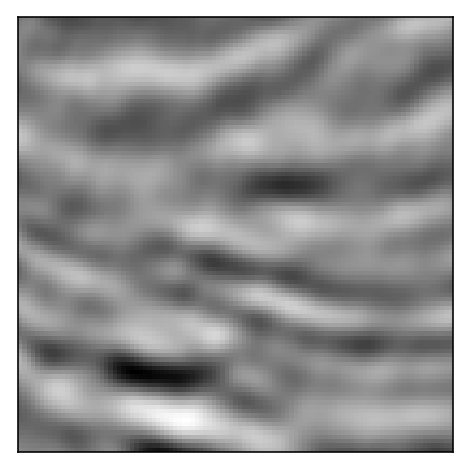

In [9]:
# Show a train image with salt
img = open_image(PATH/TRAIN_IMS/'70db04a203.png')
print('70db04a203.png')
show_img(img);

In [10]:
# Here's what the above image's raw data looks like
img.shape

(101, 101, 3)

In [11]:
img[:4,:4]

array([[[0.47059, 0.47059, 0.47059],
        [0.49412, 0.49412, 0.49412],
        [0.50196, 0.50196, 0.50196],
        [0.49412, 0.49412, 0.49412]],

       [[0.49804, 0.49804, 0.49804],
        [0.51373, 0.51373, 0.51373],
        [0.52157, 0.52157, 0.52157],
        [0.5098 , 0.5098 , 0.5098 ]],

       [[0.51373, 0.51373, 0.51373],
        [0.52549, 0.52549, 0.52549],
        [0.52941, 0.52941, 0.52941],
        [0.5098 , 0.5098 , 0.5098 ]],

       [[0.52157, 0.52157, 0.52157],
        [0.52549, 0.52549, 0.52549],
        [0.51373, 0.51373, 0.51373],
        [0.49804, 0.49804, 0.49804]]], dtype=float32)

70db04a203.png


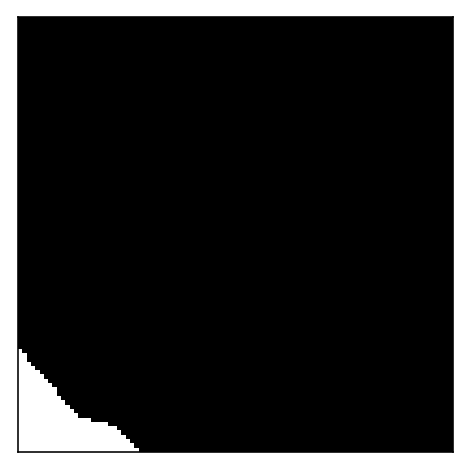

In [12]:
# Show an example of the corresponding mask from the training set
img_mask = open_image(PATH/TRAIN_MSKS/'70db04a203.png')
print('70db04a203.png')
show_img(img_mask);

In the mask above, the white pixels (with values of 1.0) indicate the presence of salt. Black pixels (with values of 0.0) indicate an absence of salt. These masks essentially serve as the training labels for each image in the training image set.

In [13]:
# Here's what the above mask image's raw data looks like
img_mask.shape

(101, 101, 3)

In [14]:
display(np.array2string(img_mask[-1][:,0]).replace('\n', ''))

'[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]'

Observe that the distribution of 1 and 0 values in the last row of the mask's array corresponds to the order of white and black pixels in the bottom row of the actual mask image above. The first roughly 1/3rd of the values are 1 (white), and the final 2/3rds are 0 (black).

In [15]:
# Plot several images chosen at random, overlaid with their masks
np.random.seed(42)
ids = list(pd.read_csv(PATH/TRAIN_FN)['id'].sample(16))

In [16]:
ims = [open_image(PATH/TRAIN_IMS/f'{ids[i]}.png') for i in range(16)]
im_masks = [open_image(PATH/TRAIN_MSKS/f'{ids[i]}.png') for i in range(16)]

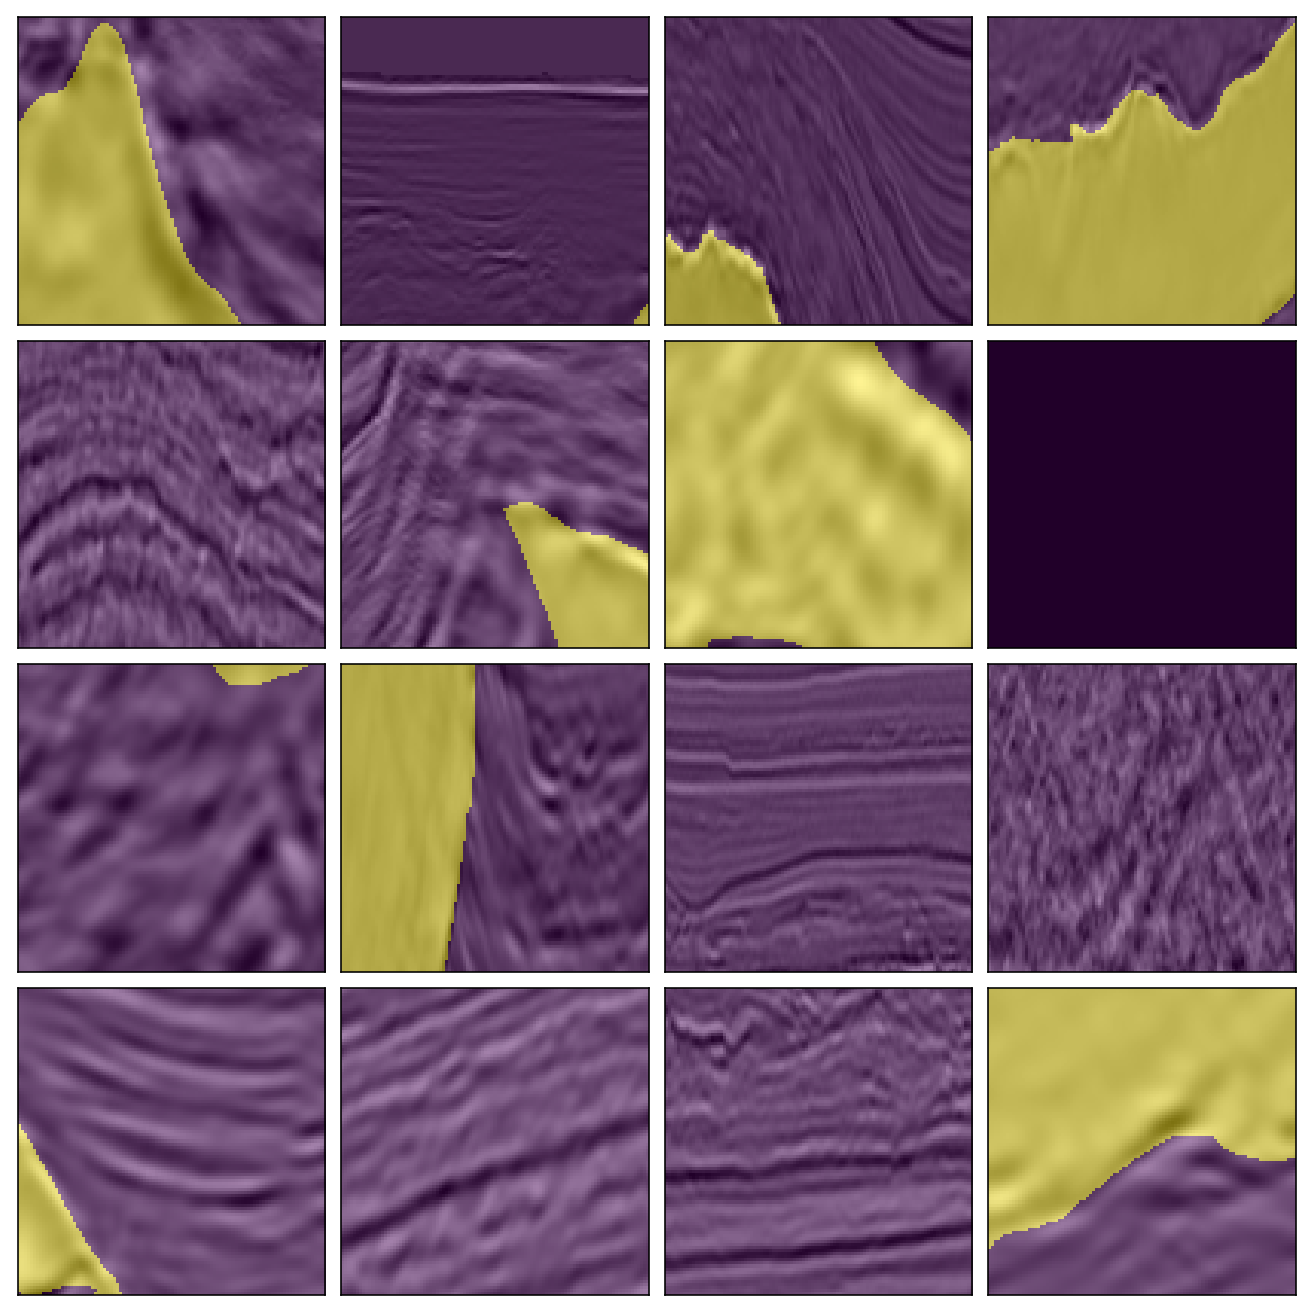

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(9, 9))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

Yellow highlights indicate salt.

In [18]:
# Let's take a look at a sample of the train.csv file
train_df = pd.read_csv(PATH/TRAIN_FN, index_col="id")
display(train_df.head(n=10))

,rle_mask
id,
575d24d81d,NaN
a266a2a9df,5051 5151
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
782ae9b7e7,1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
9842f69f8d,NaN
aa94cfb806,1 28 102 28 203 29 304 30 405 32 506 33 607 34...
50d3073821,1 2121 9293 909


In [19]:
# And here is what depths.csv looks like
depths_df = pd.read_csv(PATH/DEPTHS_FN, index_col="id")
display(depths_df.head(n=10))

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783
2ffea0c397,429
6cf284fb9e,600
d0244d6c38,51
cffbfab33b,755


In [20]:
# Join depth information to the train dataframe. Also 
# create a similar dataframe for test ids that contains 
# corresponding depths
train_df.drop('rle_mask', axis=1, inplace=True)
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [21]:
display(test_df.head())

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [22]:
display(train_df.head())

,z
id,
575d24d81d,843
a266a2a9df,794
75efad62c1,468
34e51dba6a,727
4875705fb0,797


In [23]:
len(train_df)

4000

In [24]:
len(test_df)

18000

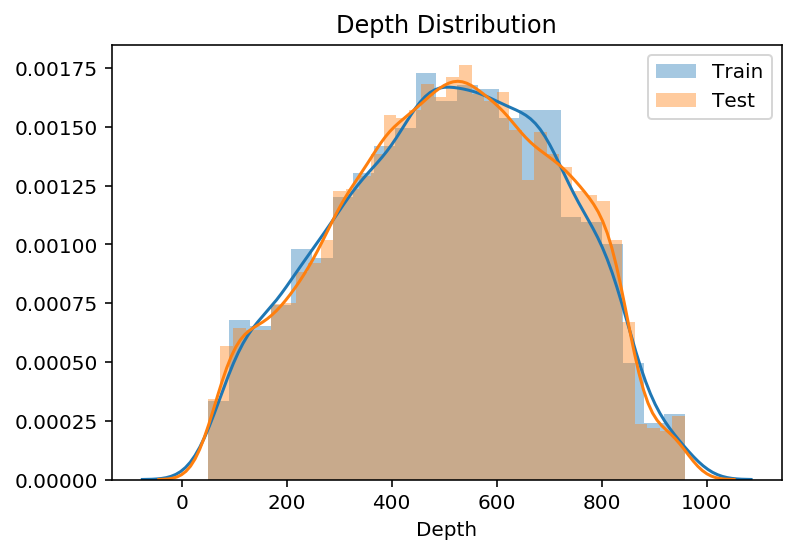

In [25]:
sns.distplot(train_df['z'], label="Train")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Depth Distribution");

In [26]:
# create depths class for stratification
train_df['z_class'] = pd.cut(train_df['z'], 8, labels=[1,2,3,4,5,6,7,8])

In [27]:
display(train_df.head())

,z,z_class
id,,
575d24d81d,843,7
a266a2a9df,794,7
75efad62c1,468,4
34e51dba6a,727,6
4875705fb0,797,7


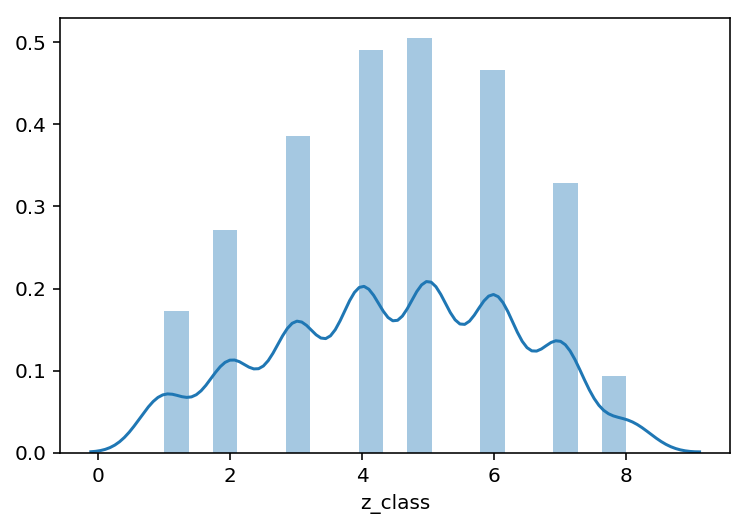

In [28]:
sns.distplot(train_df['z_class'], label="Train");

In [29]:
# create coverage class
train_df['masks'] = [np.array(open_image(PATH/TRAIN_MSKS/f'{i}.png')) for i in list(train_df.index)]

In [30]:
train_df['cov'] = train_df['masks'].map(lambda x: np.sum(x)/3)

In [31]:
train_df.drop('masks', axis=1, inplace=True)

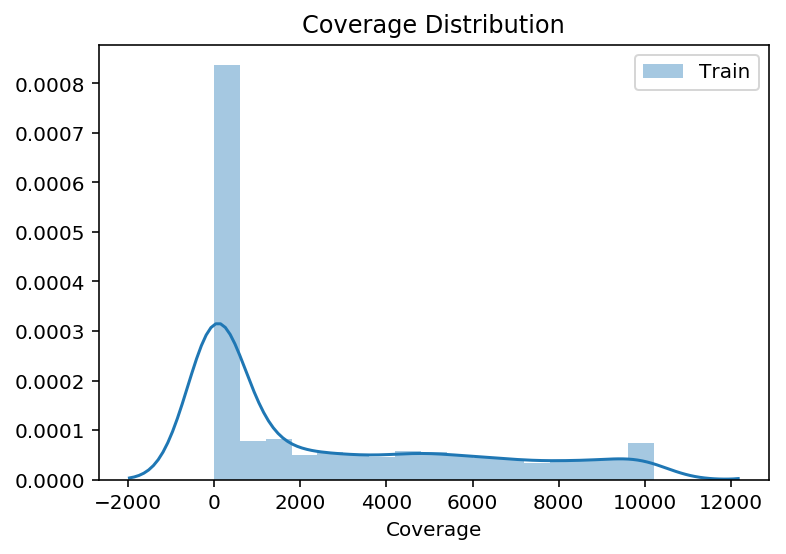

In [32]:
sns.distplot(train_df['cov'], label="Train")
plt.legend()
plt.xlabel('Coverage')
plt.title('Coverage Distribution');

In [33]:
train_df['cov_class'] = pd.cut(train_df['cov'], 8, labels=[1,2,3,4,5,6,7,8])

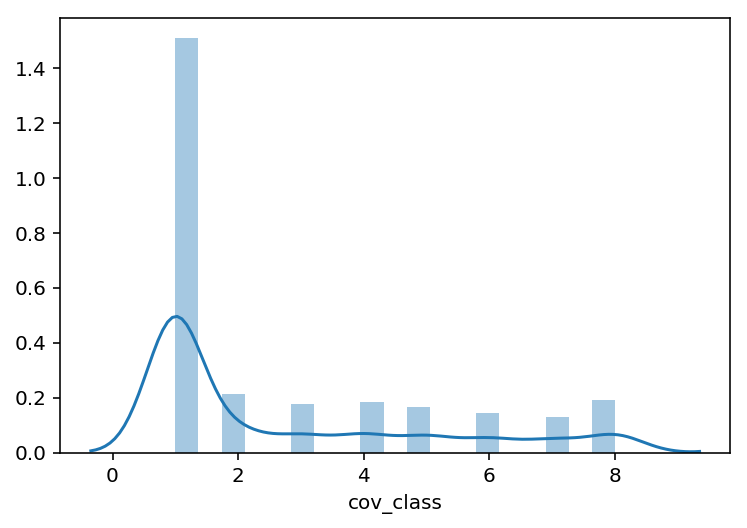

In [34]:
sns.distplot(train_df['cov_class'], label='Train');

In [35]:
train_df['im_path'] = train_df.index.map(lambda x: Path(TRAIN_IMS)/f'{x}.png')
                                         

In [36]:
train_df['msk_path'] = train_df.index.map(lambda x: Path(TRAIN_MSKS)/f'{x}.png')


In [37]:
display(train_df.head())

,z,z_class,cov,cov_class,im_path,msk_path
id,,,,,,
575d24d81d,843,7,0.0,1,train_images/575d24d81d.png,train_masks/575d24d81d.png
a266a2a9df,794,7,5151.0,5,train_images/a266a2a9df.png,train_masks/a266a2a9df.png
75efad62c1,468,4,10133.0,8,train_images/75efad62c1.png,train_masks/75efad62c1.png
34e51dba6a,727,6,1522.0,2,train_images/34e51dba6a.png,train_masks/34e51dba6a.png
4875705fb0,797,7,437.0,1,train_images/4875705fb0.png,train_masks/4875705fb0.png


### Split Validation off from Train Set

In [38]:
train, val = train_test_split(train_df, test_size=0.2, stratify=train_df['z_class'])

In [39]:
len(train)

3200

In [40]:
len(val)

800

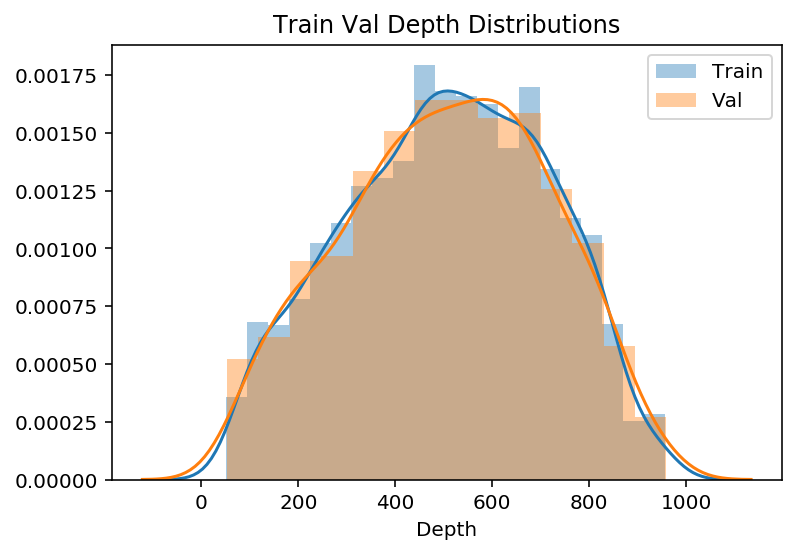

In [41]:
sns.distplot(train['z'], label="Train")
sns.distplot(val['z'], label="Val")
plt.legend()
plt.xlabel('Depth')
plt.title("Train Val Depth Distributions");

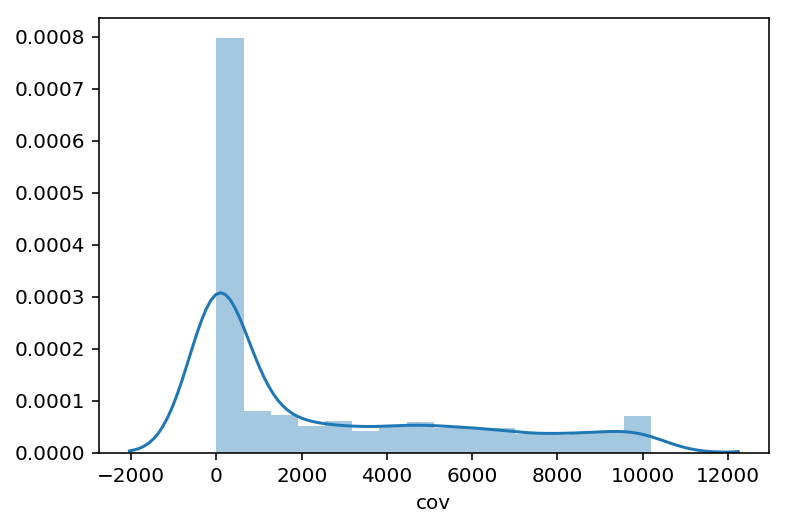

In [42]:
sns.distplot(train['cov'], label="Train");

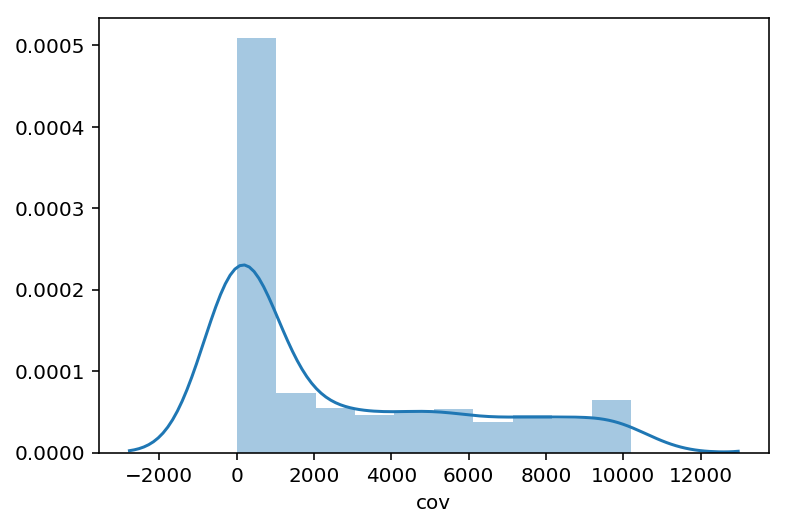

In [43]:
sns.distplot(val['cov'], label="Val");

## Dataset

In [44]:
trn_x = np.array(train['im_path'])
val_x = np.array(val['im_path'])
trn_y = np.array(train['msk_path'])
val_y = np.array(val['msk_path'])

In [45]:
test_df['im_path'] = test_df.index.map(lambda x: Path(TEST_IMS)/f'{x}.png')

In [46]:
tst_x = np.array(test_df['im_path'])

In [47]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [48]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [49]:
arch = resnet34
sz=128
bs = 6

In [50]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)

In [51]:
def get_augs():
    denorm = md.trn_ds.denorm
    x,y = next(iter(md.aug_dl))
    x = denorm(x)
    return x, y

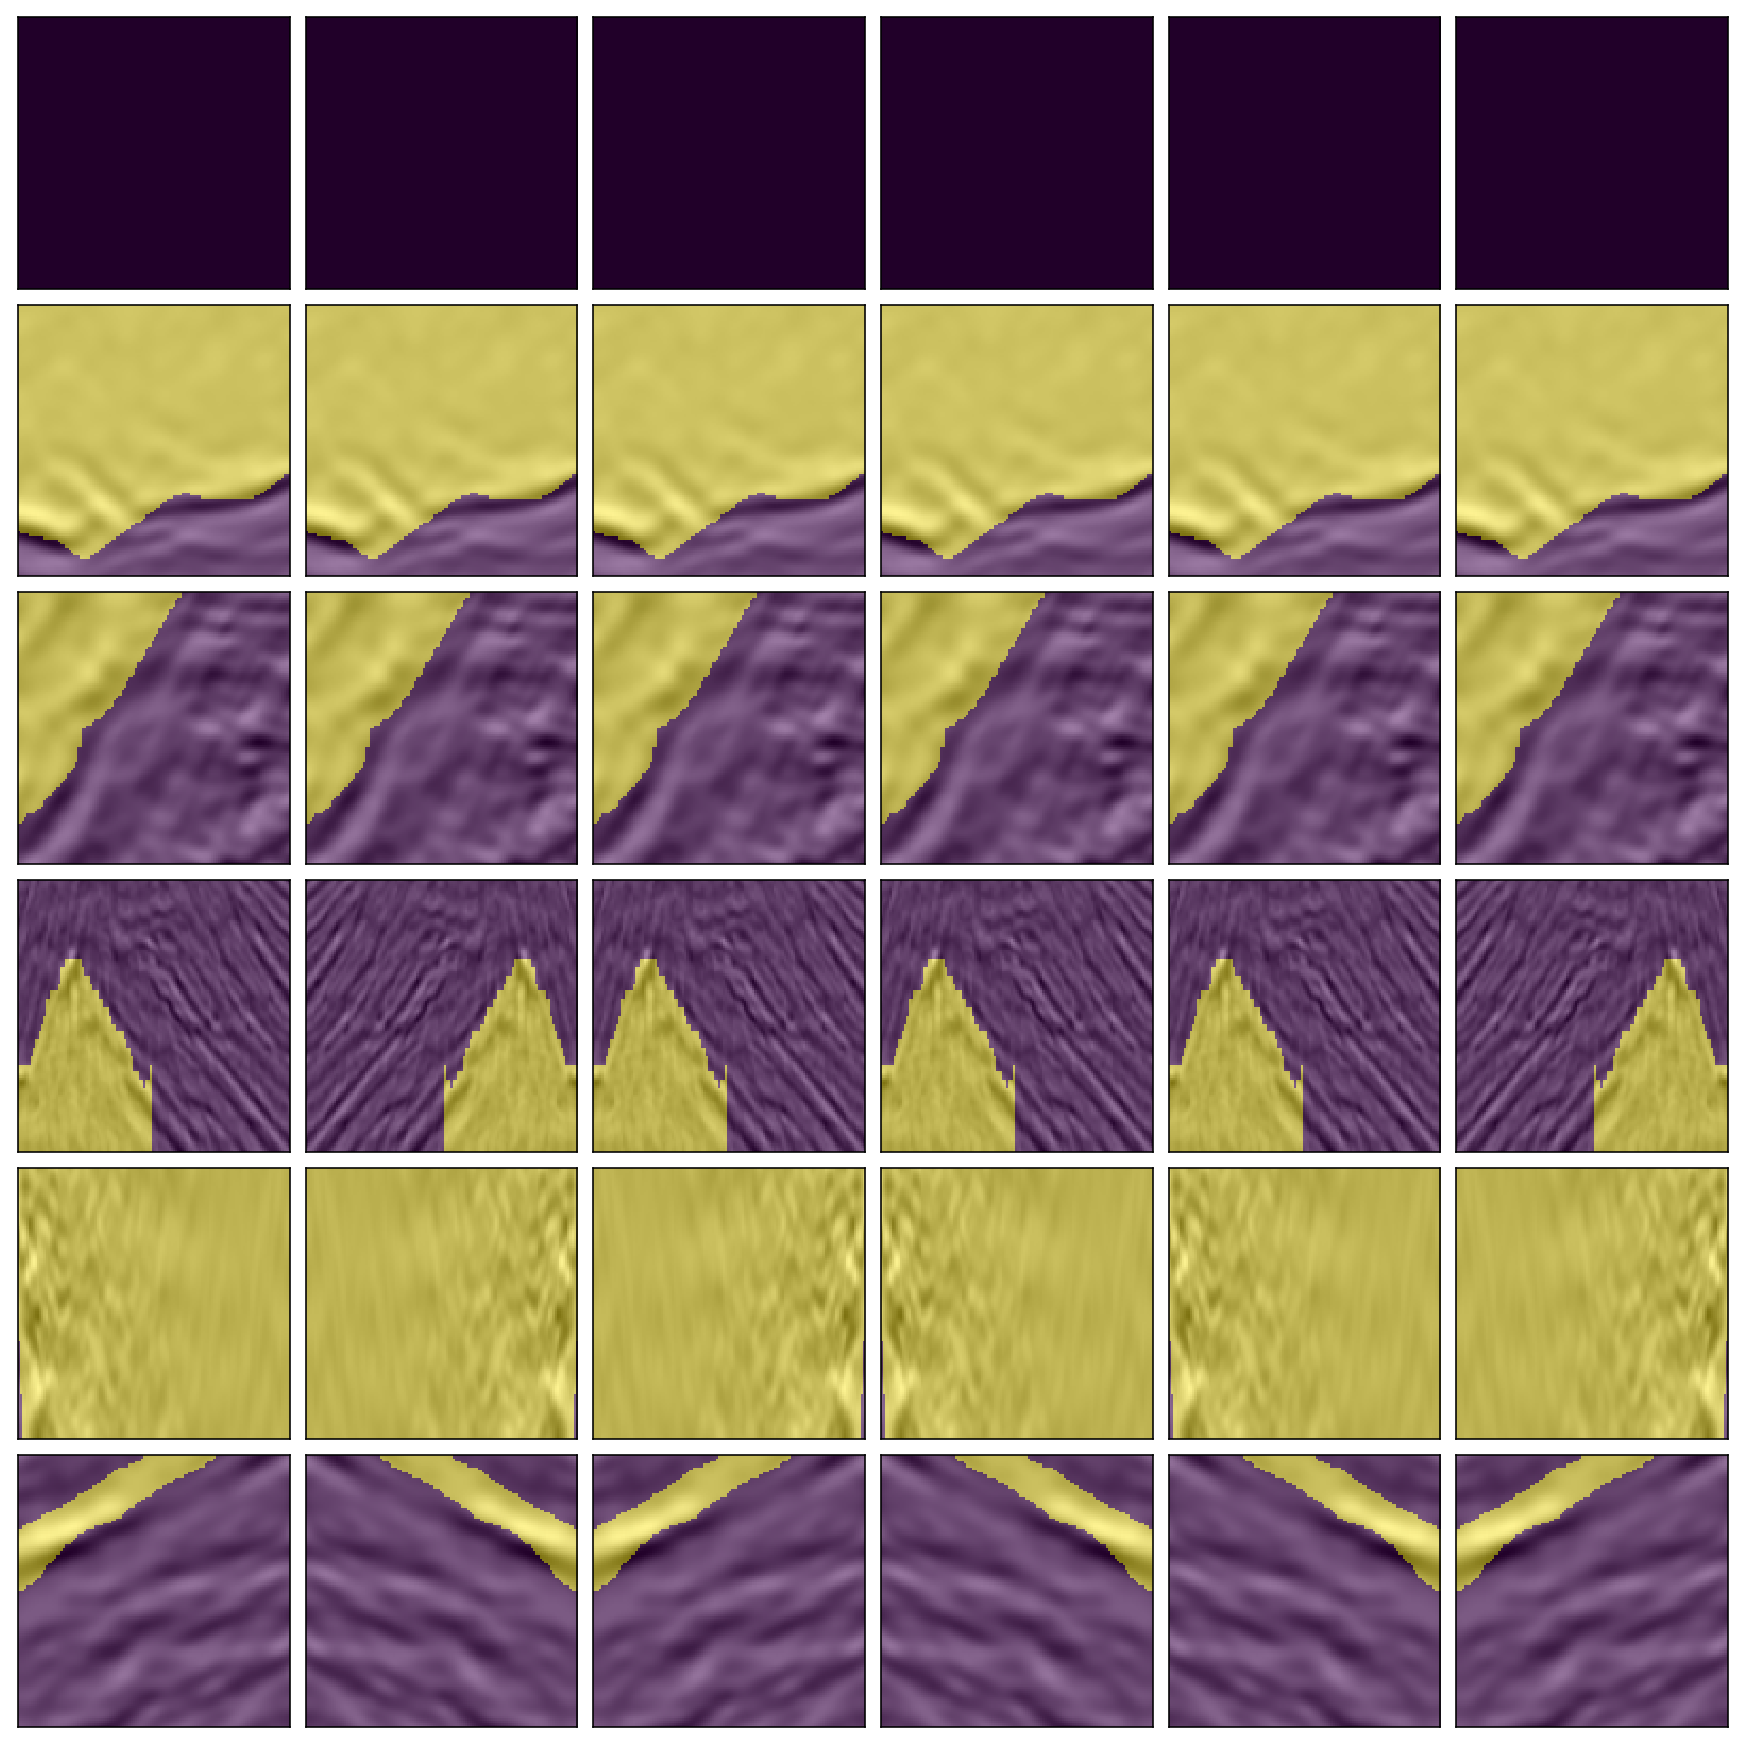

In [52]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
for row in axes.T:
    x, y = get_augs()
    for i, ax in enumerate(row):
        ax=show_img(x[i%6], ax=ax)
        show_img(y[i%6].cpu(), ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## U-Net with Resnet34 Backbone

In [53]:
ARCH = resnet34
MODEL_NAME = 'unet_resnet34'

In [54]:
cut, lr_cut = model_meta[ARCH]

In [55]:
def get_base():
    layers = cut_model(ARCH(True), cut)
    return nn.Sequential(*layers)

In [56]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [67]:
# Concurrent Spatial and Channel Squeeze & Excitation
# From https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66178

class CSE(nn.Module):
    def __init__(self, in_ch, r):
        super(CSE, self).__init__()
        self.linear_1 = nn.Linear(in_ch, in_ch//r)
        self.linear_2 = nn.Linear(in_ch//r, in_ch)

    def forward(self, x):
        input_x = x
        x = x.view(*(x.shape[:-2]),-1).mean(-1)
        x = F.relu(self.linear_1(x), inplace=True)
        x = self.linear_2(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = torch.sigmoid(x)
        x = input_x * x
        return x
    
class SSE(nn.Module):
    def __init__(self, in_ch):
        super(SSE, self).__init__()
        self.conv = nn.Conv2d(in_ch, 1, kernel_size=1, stride=1)

    def forward(self, x):
        input_x = x
        x = self.conv(x)
        x = torch.sigmoid(x)
        x = input_x * x
        return x

class SCSE(nn.Module):
    def __init__(self, in_ch, r):
        super(SCSE, self).__init__()
        self.cSE = CSE(in_ch, r)
        self.sSE = SSE(in_ch)

    def forward(self, x):
        cSE = self.cSE(x)
        sSE = self.sSE(x)
        x = cSE + sSE
        return x

In [58]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv = nn.Conv2d(x_in, x_out, 1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        self.scse = SCSE(n_out, 16)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.scse(self.bn(F.relu(cat_p)))

In [59]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2, 4, 5, 6]]
        self.up1 = UnetBlock(512,256,128)
        self.up2 = UnetBlock(128,128,128)
        self.up3 = UnetBlock(128,64,128)
        self.up4 = UnetBlock(128,64,128)
        self.up5 = nn.ConvTranspose2d(128,1,2,stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        d1 = self.up1(x, self.sfs[3].features)
        d2 = self.up2(d1, self.sfs[2].features)
        d3 = self.up3(d2, self.sfs[1].features)
        d4 = self.up4(d3, self.sfs[0].features)
        d5 = self.up5(d4)
        return d5[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [60]:
class UnetModel():
    def __init__(self, model, name=MODEL_NAME):
        self.model, self.name = model, name
        
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

### Lovasz Loss

In [61]:
# Calculating Lovasz Hinge Loss
# https://arxiv.org/abs/1705.08790
# https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [62]:
def lovasz_loss(logits, labels):
    labels, logits = labels.squeeze(1), logits.squeeze(1)
    labels = torch.Tensor(labels.data.cpu().numpy()).cuda()
    loss = lovasz_hinge(logits, labels, per_image = True, ignore = None)
    return loss

### Competition Metric (IOU)

In [63]:
# The evaluation metric: mean average precision at 
# different intersection over union (IoU) thresholds.

# Inspired by Kerem Turgutlu:
# https://github.com/KeremTurgutlu/airbus/blob/master/eval_metric.py

def IOU(pred, targ):
    smooth = 1e-6
    intersection = np.sum(pred * targ)
    union = np.sum((pred + targ) > 0)
    return (intersection + smooth) / (union + smooth)

def avg_precision_IOU(pred, targ):
    IOU_score = IOU(pred, targ)
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        prec.append((IOU_score > t).astype('uint8'))
    return np.mean(prec)

def mean_avg_precision_IOU(preds, targs, thresh=0.0):
    scores = []
    preds = (to_np(preds) > thresh).astype('uint8')
    targs = to_np(targs)
    for i, (pred_i, targ_i) in enumerate(zip(preds, targs)):
        pred_i, targ_i = scale_min(pred_i, 101), scale_min(targ_i, 101)
        scores.append(avg_precision_IOU(pred_i, targ_i))
    return np.mean(scores)

## Single Fold CV Split

### Progressive resizing with use_clr

### 64x64

In [68]:
sz=64
bs=128
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]
learn.crit=nn.BCEWithLogitsLoss()
learn.freeze_to(1)

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      1.138269   6.778834998825845e+16 0.0       



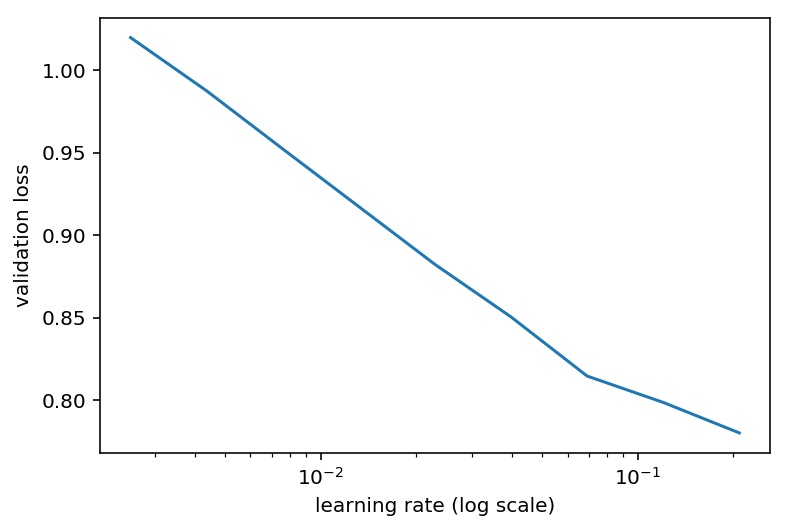

In [69]:
learn.lr_find()
learn.sched.plot()

In [70]:
sz=64
bs=128
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
wd=1e-2
lrs = np.array([lr/9,lr/3,lr])

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

learn.crit=nn.BCEWithLogitsLoss()
learn.freeze_to(1)
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp0')
learn.load('64-tmp0')
learn.crit=lovasz_loss
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp1')
learn.load('64-tmp1')
learn.crit=nn.BCEWithLogitsLoss()
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp2')
learn.load('64-tmp2')
learn.crit=lovasz_loss
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs/2,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='64')

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.335162   0.768805   0.5325    
    1      0.249066   0.18347    0.5945                    
    2      0.204736   0.178232   0.605875                  
    3      0.177641   0.155139   0.6515                    
    4      0.152122   0.164787   0.663125                  



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.614832   0.650635   0.6355    
    1      0.532606   0.554199   0.669                     
    2      0.481487   0.509687   0.688375                  
    3      0.439327   0.502644   0.699875                  
    4      0.407796   0.46244    0.715375                  



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.194842   0.217633   0.614375  
    1      0.16737    0.209059   0.664875                  
    2      0.147975   0.177562   0.713125                  
    3      0.13133    0.151716   0.701875                  
    4      0.121691   0.160227   0.679875                  
    5      0.107463   0.178385   0.710125                  
    6      0.093972   0.186323   0.7115                     
    7      0.083296   0.163784   0.723125                   
    8      0.074058   0.14918    0.721                      
    9      0.066738   0.15432    0.73225                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.384523   0.507716   0.724875  
    1      0.33129    0.484585   0.731375                  
    2      0.306756   0.458309   0.738625                  
    3      0.287242   0.462572   0.728                     
    4      0.271092   0.503535   0.71775                   
    5      0.264914   0.45985    0.734625                  
    6      0.257234   0.458095   0.742                     
    7      0.250997   0.451367   0.7315                    
    8      0.240544   0.449787   0.734375                  
    9      0.233024   0.443916   0.73525                   
    10     0.22802    0.457619   0.731125                  
    11     0.221216   0.42816    0.741125                  
    12     0.21251    0.435935   0.7385                    
    13     0.206101   0.423077   0.75175                   
    14     0.199729   0.43756    0.734875                  
    15     0.193428   0.421794   0.75475                

[0.4262860941886902, 0.7472500000000001]

### 128x128

In [71]:
sz=128
bs=128
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
wd=1e-2
lrs = np.array([lr/9,lr/3,lr])

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

learn.load('64')
learn.crit=nn.BCEWithLogitsLoss()
learn.freeze_to(1)
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp0')
learn.load('128-tmp0')
learn.crit=lovasz_loss
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp1')
learn.load('128-tmp1')
learn.crit=nn.BCEWithLogitsLoss()
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp2')
learn.load('128-tmp2')
learn.crit=lovasz_loss
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs/2,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='128')

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.177273   0.195566   0.653625  
    1      0.152415   0.156856   0.71875                   
    2      0.135982   0.151492   0.721                     
    3      0.122825   0.149299   0.720875                  
    4      0.108356   0.150069   0.728875                  



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.459356   0.583004   0.690125  
    1      0.399874   0.451725   0.7405                    
    2      0.36795    0.439785   0.738375                  
    3      0.337975   0.436495   0.737                     
    4      0.319844   0.419323   0.74625                   



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.175522   0.220677   0.59425   
    1      0.149195   0.203188   0.6985                    
    2      0.135575   0.161057   0.678                     
    3      0.120621   0.146856   0.73575                   
    4      0.10204    0.138822   0.74                      
    5      0.091508   0.146284   0.75225                    
    6      0.083266   0.169724   0.73425                    
    7      0.075704   0.158521   0.7445                     
    8      0.068859   0.146453   0.754125                   
    9      0.061598   0.140528   0.75925                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.314179   0.478484   0.751125  
    1      0.281217   0.435925   0.7515                    
    2      0.261776   0.434004   0.754375                  
    3      0.249148   0.405753   0.764125                  
    4      0.243433   0.411278   0.759625                  
    5      0.234228   0.405136   0.761375                  
    6      0.232221   0.405406   0.764625                  
    7      0.223084   0.389221   0.767625                  
    8      0.213906   0.376417   0.76925                   
    9      0.206336   0.374978   0.77275                   
    10     0.200499   0.398679   0.760625                  
    11     0.19461    0.379651   0.770625                  
    12     0.189313   0.380889   0.767375                  
    13     0.186296   0.371019   0.777625                  
    14     0.180858   0.376558   0.771875                  
    15     0.176706   0.373753   0.772375               

[0.35405170917510986, 0.7823749999999999]

### 256x256 All but final round

In [72]:
sz=256
bs=64
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
wd=1e-2
lrs = np.array([lr/9,lr/3,lr])

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

learn.load('128')
learn.crit=nn.BCEWithLogitsLoss()
learn.freeze_to(1)
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp0')
learn.load('256-tmp0')
learn.crit=lovasz_loss
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp1')
learn.load('256-tmp1')
learn.crit=nn.BCEWithLogitsLoss()
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp2')

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.180951   0.177161   0.67825   
    1      0.158795   0.169377   0.68425                   
    2      0.144402   0.146807   0.707625                  
    3      0.131884   0.136397   0.728125                  
    4      0.118117   0.12952    0.733                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.448405   0.483183   0.72725   
    1      0.417384   0.452313   0.739                     
    2      0.379634   0.417818   0.749                     
    3      0.349045   0.403367   0.75525                   
    4      0.325407   0.393777   0.757625                  



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.196633   0.190784   0.636375  
    1      0.160895   0.203195   0.638                     
    2      0.138808   0.14363    0.742125                  
    3      0.124006   0.137809   0.736125                  
    4      0.118473   0.13505    0.734625                  
    5      0.11282    0.150526   0.709                     
    6      0.103573   0.129578   0.73325                   
    7      0.092834   0.137329   0.7475                     
    8      0.080695   0.126595   0.7575                     
    9      0.068962   0.117409   0.770625                   



[0.1174094009399414, 0.770625]

### Callback - Get best n models from from n runs of final training round

In [74]:
# N run (Take best n best snapshot across n runs)

# Callback - get N best models
# Inspired by Ismaël Koné's SaveBestModel() class:
# http://forums.fast.ai/t/a-code-snippet-to-save-the-best-model-during-training/12066
from operator import itemgetter

class SaveTopNModels(LossRecorder):
    def __init__(self, learn, lr, name, fold, n_saved=2, run=1,final_run=False,best_models=[]):
        super().__init__(learn.get_layer_opt(lr,None))
        self.learn = learn
        self.name = name
        self.fold = fold
        self.n_saved = n_saved
        self.run = run
        self.final_run = final_run
        self.best_models = best_models
        self.epoch_cnt = 0
        
    def on_epoch_end(self,metrics):
        super().on_epoch_end(metrics)
        iou_score = metrics[1]
        model_name = self.name + f'_fold_{self.fold}_run_{self.run}_epoch_{self.epoch_cnt}'
        if self.epoch_cnt>0 or len(self.best_models)>0: worst_score = min(self.best_models, key=itemgetter(1))[1]
        if len(self.best_models) < self.n_saved:  
            self.best_models.append((model_name,iou_score))
            self.learn.save(model_name)
        elif iou_score > worst_score:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            name_to_del = self.best_models[-1][0]
            del self.best_models[-1]
            os.remove(PATH/MODELS/f'{name_to_del}.h5')
            self.best_models.append((model_name,iou_score))
            self.learn.save(model_name)
        self.epoch_cnt += 1
    
    def on_train_end(self):
        if self.final_run:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            print(self.best_models)
            for i, item in enumerate(self.best_models):
                new_name = self.name + f'_single_fold_snapshot_{i+1}'
                print(f'{item[0]}.h5')
                print(new_name)
                os.rename(PATH/MODELS/f'{item[0]}.h5', PATH/MODELS/f'{new_name}.h5')
                self.best_models[i] = (new_name, item[1])

### 256x256 Final Round (done n times)

In [75]:
# N Run
N_SNAPSHOTS = 10
N_FOLD=1
n_runs=3

sz=256
bs=64
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
lrs = np.array([lr/9,lr/3,lr])
wd=7e-3
# wd=1e-2

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

# N-Run training for final training cycle. Use SaveTopNModels() class
# to get top n models across both runs combined.
best_models = []
for i in range(n_runs):
    learn.load('256-tmp2')
    learn.crit=lovasz_loss
    learn.unfreeze()
    learn.bn_freeze(False)
    save_best_n = SaveTopNModels(learn, lrs, MODEL_NAME, N_FOLD, n_saved=N_SNAPSHOTS, run=i+1, final_run=(i==n_runs-1),best_models=best_models)
    learn.fit(lrs/2,1,wds=wd,use_wd_sched=True,cycle_len=30,use_clr=(20,30,0.95,0.85),callbacks=[save_best_n])
    best_models = save_best_n.best_models

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.367059   0.48193    0.754     
    1      0.307138   0.417827   0.7655                    
    2      0.286025   0.413771   0.764                     
    3      0.273634   0.411061   0.758125                  
    4      0.254455   0.371095   0.7745                    
    5      0.262179   0.379313   0.773625                  
    6      0.24989    0.394195   0.768125                  
    7      0.245468   0.383611   0.7735                    
    8      0.237336   0.374637   0.769875                  
    9      0.223482   0.376527   0.771125                  
    10     0.223938   0.364133   0.774125                  
    11     0.218421   0.388885   0.772                     
    12     0.216637   0.372245   0.776375                  
    13     0.216919   0.357419   0.78225                   
    14     0.210879   0.376115   0.769625                  
    15     0.211128   0.380503   0.767875               

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.341036   0.436528   0.77      
    1      0.305764   0.399349   0.762625                  
    2      0.28526    0.398443   0.7625                    
    3      0.277265   0.432526   0.745                     
    4      0.269784   0.40601    0.757                     
    5      0.268828   0.398251   0.758                     
    6      0.261793   0.407209   0.763                     
    7      0.255983   0.397409   0.76675                   
    8      0.254069   0.405371   0.756625                  
    9      0.242987   0.356768   0.7755                    
    10     0.236387   0.363444   0.7765                    
    11     0.230159   0.37051    0.774625                  
    12     0.224797   0.365731   0.773375                  
    13     0.218952   0.385871   0.763125                  
    14     0.210876   0.356144   0.780875                  
    15     0.208367   0.34732    0.7775                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.362325   0.419245   0.76775   
    1      0.309937   0.396095   0.767                     
    2      0.284528   0.399276   0.761125                  
    3      0.277294   0.407749   0.762625                  
    4      0.267005   0.408246   0.760875                  
    5      0.279418   0.436544   0.74375                   
    6      0.261487   0.401228   0.755625                  
    7      0.25312    0.370551   0.773125                  
    8      0.237952   0.360806   0.777                     
    9      0.233063   0.37296    0.770125                  
    10     0.225644   0.358524   0.777625                  
    11     0.228973   0.378719   0.77125                   
    12     0.229089   0.370074   0.775375                  
    13     0.219209   0.361524   0.77375                   
    14     0.211925   0.399485   0.7575                    
    15     0.219521   0.378164   0.772375               

In [76]:
best_models

[('unet_resnet34_single_fold_snapshot_1', 0.7957500000000001),
 ('unet_resnet34_single_fold_snapshot_2', 0.7948750000000001),
 ('unet_resnet34_single_fold_snapshot_3', 0.793125),
 ('unet_resnet34_single_fold_snapshot_4', 0.792875),
 ('unet_resnet34_single_fold_snapshot_5', 0.792),
 ('unet_resnet34_single_fold_snapshot_6', 0.791375),
 ('unet_resnet34_single_fold_snapshot_7', 0.791375),
 ('unet_resnet34_single_fold_snapshot_8', 0.791125),
 ('unet_resnet34_single_fold_snapshot_9', 0.790625),
 ('unet_resnet34_single_fold_snapshot_10', 0.7901249999999999)]

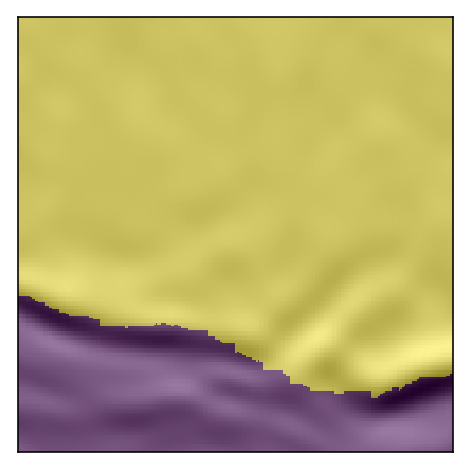

In [77]:
learn.load(best_models[0][0])
denorm = md.trn_ds.denorm
x, y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[1])
show_img(py[1]>0, ax=ax, alpha=0.5);

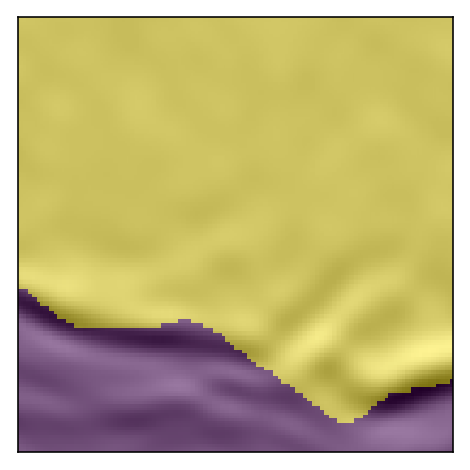

In [79]:
ax = show_img(denorm(x)[1])
show_img(y[1].cpu(), ax=ax, alpha=0.5);

In [80]:
m.close()

## Single Fold Validation Predictions

In [81]:
class TestFilesDataset(FilesDataset):
    def __init__(self,fnames,y,transform,flip,path):
        self.y = y
        self.flip = flip
        super().__init__(fnames,transform,path)
        
    def get_x(self,i):
        im = open_image(os.path.join(self.path,self.fnames[i]))
        return np.fliplr(im) if self.flip else im
    
    def get_y(self, i):
        im = open_image(os.path.join(str(self.path), str(self.y[i])))
        return np.fliplr(im) if self.flip else im
    
    def get_c(self): return 0

In [82]:
sz=256
bs=32

val_preds = np.zeros(shape=(800,sz,sz))
targs = np.zeros(shape=(800,sz,sz))
for i in tqdm_notebook(range(N_SNAPSHOTS)):
    for o in [True,False]:
        tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
        datasets = ImageData.get_ds(TestFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), flip=o, path=PATH)
        md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
        m_base = get_base()
        m = to_gpu(Unet34(m_base))
        models = UnetModel(m)
        learn = ConvLearner(md, models)
        learn.opt_fn = optim.Adam
        learn.crit=nn.BCEWithLogitsLoss()
        learn.metrics=[mean_avg_precision_IOU]
        learn.load(best_models[i][0])
        learn.model.eval()

        preds, targs = learn.predict_with_targs(is_test=False)
        for im_idx, im in enumerate(preds):
            val_preds[im_idx] += np.fliplr(im) if o else im
        del preds


In [83]:
val_preds.shape

(800, 256, 256)

In [84]:
val_preds = val_preds/(N_SNAPSHOTS*2)

In [85]:
# Find best IOU threshold
scores = []
thresh = []
for i in tqdm_notebook(range(-40,41,1)):
    t = i/100
    thresh.append(t)
    scores.append(mean_avg_precision_IOU(val_preds, targs, t))

In [86]:
thresholds = pd.DataFrame({'Thresholds': thresh, 'IOU Scores': scores})

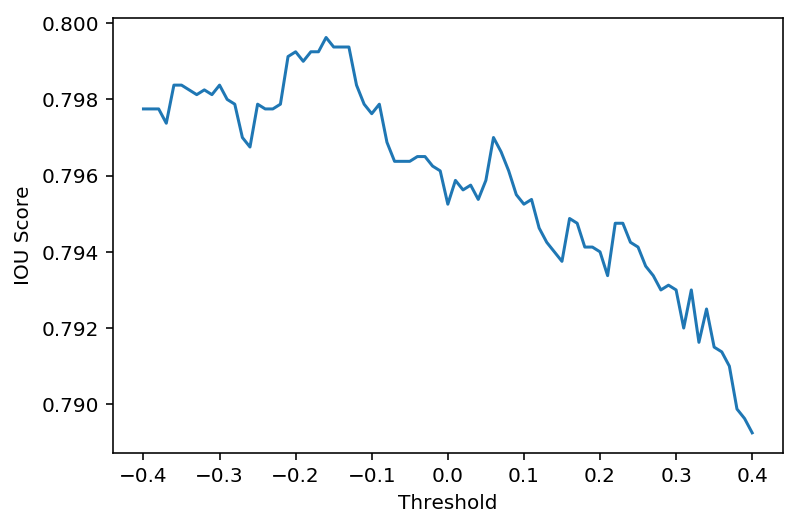

In [87]:
thresholds = thresholds.set_index('Thresholds')
plt.xlabel('Threshold')
plt.ylabel('IOU Score')
plt.plot(thresholds);

In [88]:
best_t = thresholds['IOU Scores'].argmax()
val_iou_score = mean_avg_precision_IOU(val_preds, targs, best_t)

In [89]:
best_t

-0.16

In [90]:
val_iou_score

0.7996249999999999

## N-Fold CV

### Create N-fold depth-stratified splits

In [65]:
train_df.sort_values('z', inplace=True)

In [66]:
n_folds = 8
depths = train_df['z']
# Thanks to n01z3 at https://www.kaggle.com/drn01z3/create-k-fold-splits-depths-stratified
train_df['fold'] = (list(range(n_folds))*depths.shape[0])[:depths.shape[0]]

In [67]:
f_one = train_df[train_df['fold'] == 0]
f_two = train_df[train_df['fold'] == 1]
f_three = train_df[train_df['fold'] == 2]
f_four = train_df[train_df['fold'] == 3]
f_five = train_df[train_df['fold'] == 4]

f_six = train_df[train_df['fold'] == 5]
f_seven = train_df[train_df['fold'] == 6]
f_eight = train_df[train_df['fold'] == 7]

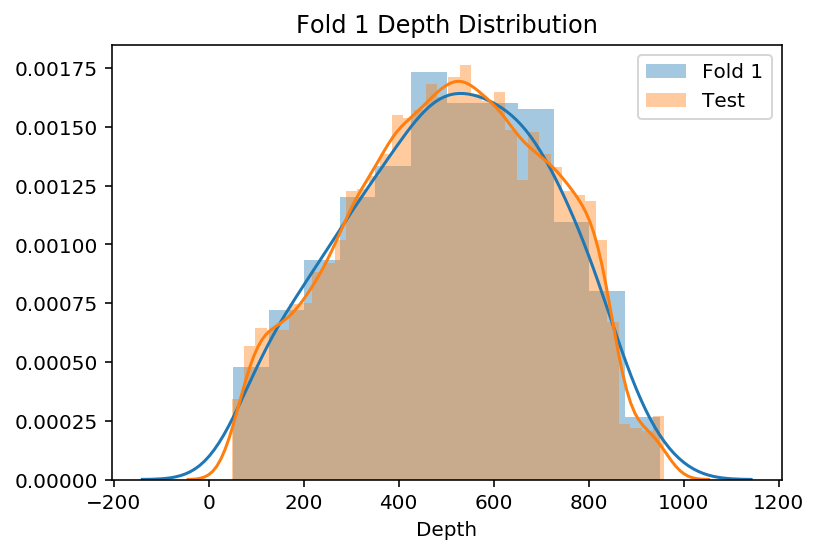

In [68]:
sns.distplot(f_one['z'], label="Fold 1")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 1 Depth Distribution");

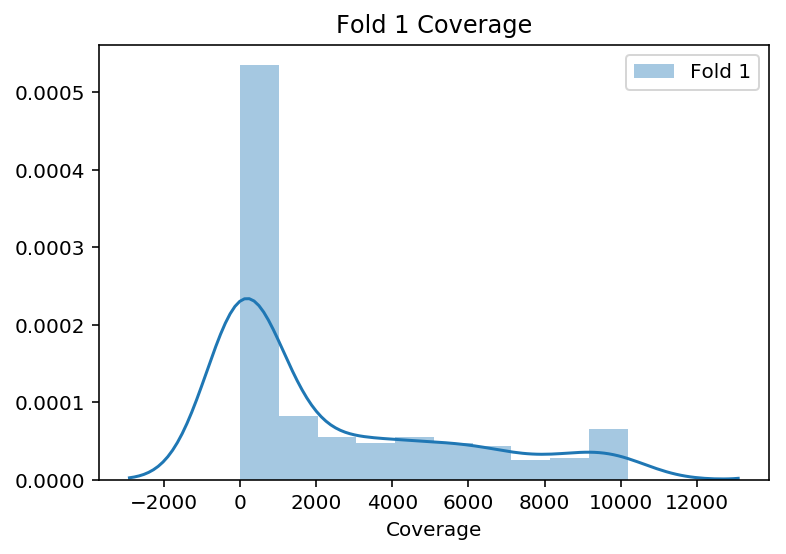

In [69]:
sns.distplot(f_one['cov'], label="Fold 1");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 1 Coverage");

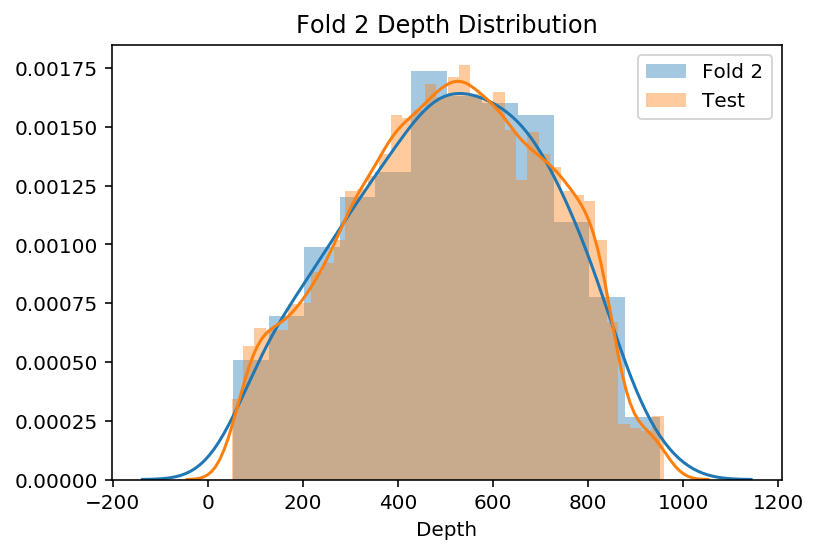

In [70]:
sns.distplot(f_two['z'], label="Fold 2")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 2 Depth Distribution");

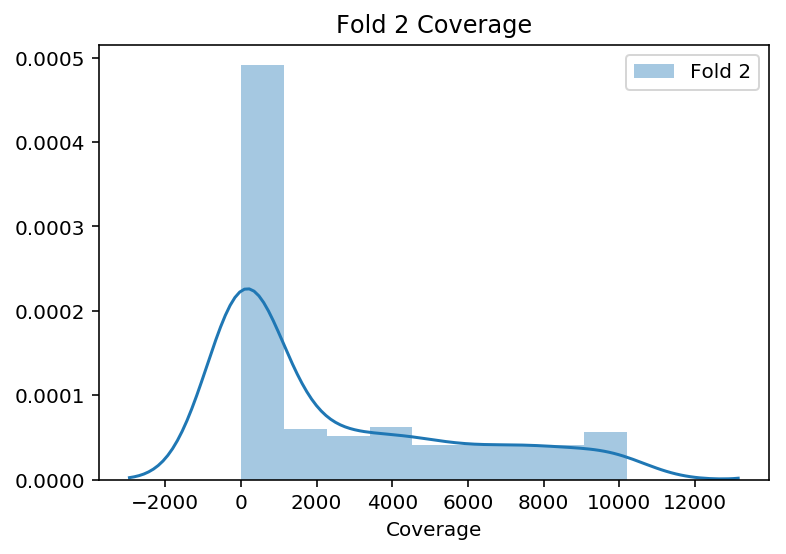

In [71]:
sns.distplot(f_two['cov'], label="Fold 2");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 2 Coverage");

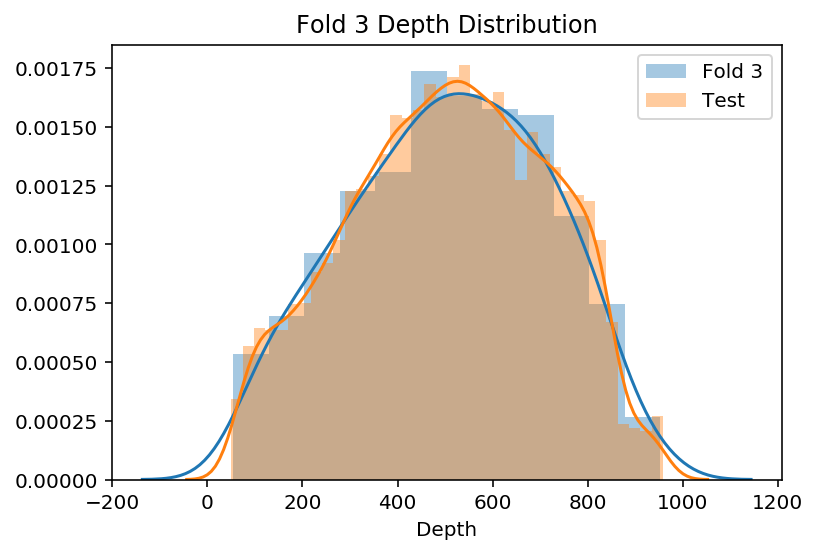

In [72]:
sns.distplot(f_three['z'], label="Fold 3")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 3 Depth Distribution");

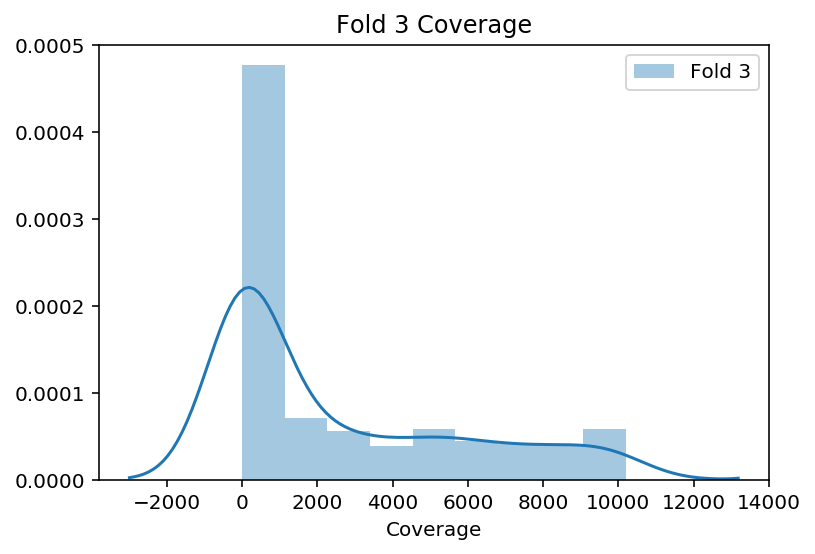

In [73]:
sns.distplot(f_three['cov'], label="Fold 3");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 3 Coverage");

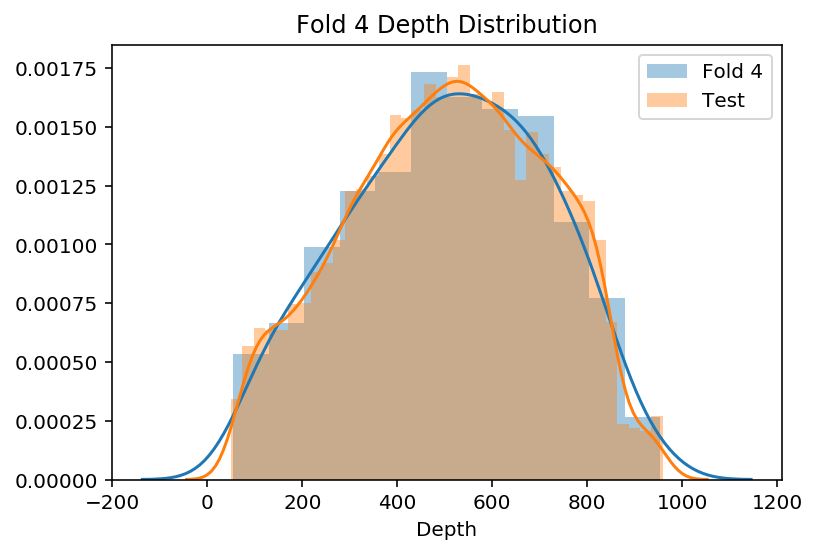

In [74]:
sns.distplot(f_four['z'], label="Fold 4")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 4 Depth Distribution");

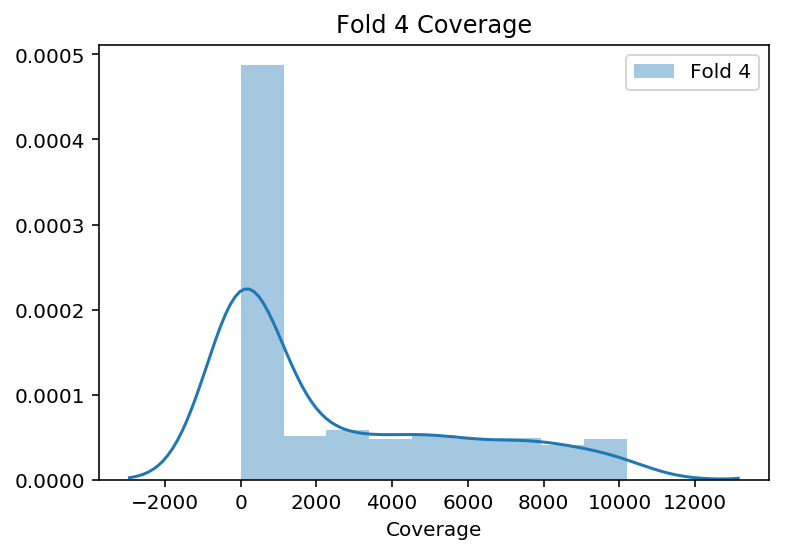

In [75]:
sns.distplot(f_four['cov'], label="Fold 4");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 4 Coverage");

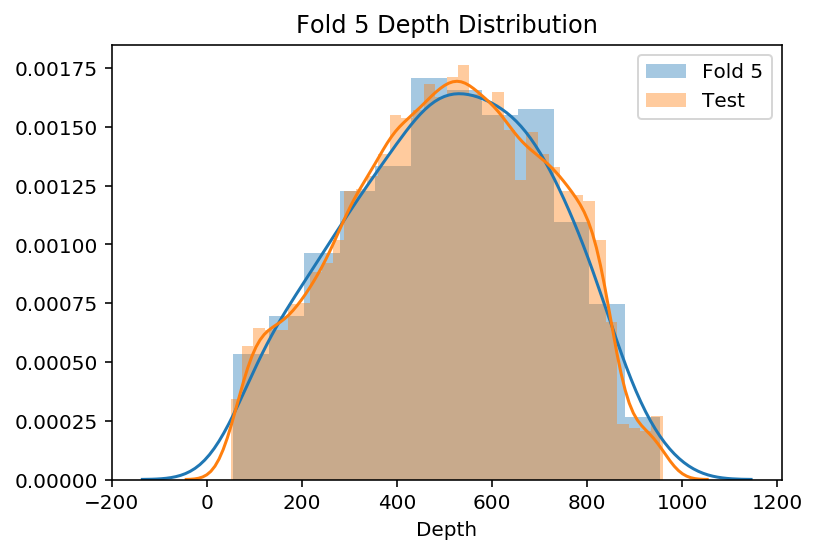

In [76]:
sns.distplot(f_five['z'], label="Fold 5")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 5 Depth Distribution");

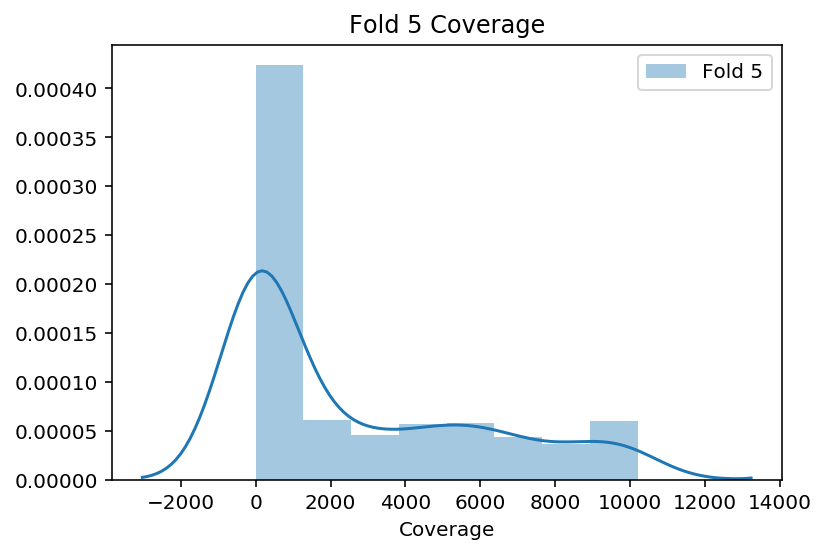

In [77]:
sns.distplot(f_five['cov'], label="Fold 5");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 5 Coverage");

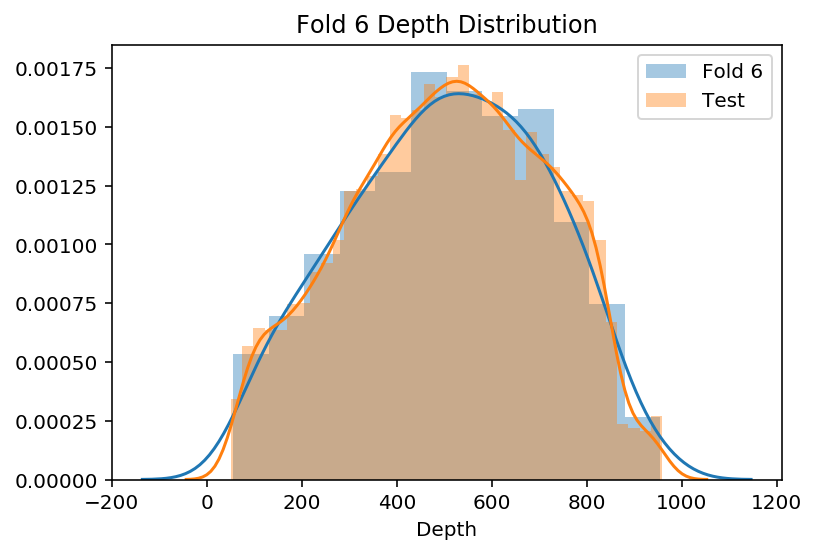

In [78]:
sns.distplot(f_six['z'], label="Fold 6")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 6 Depth Distribution");

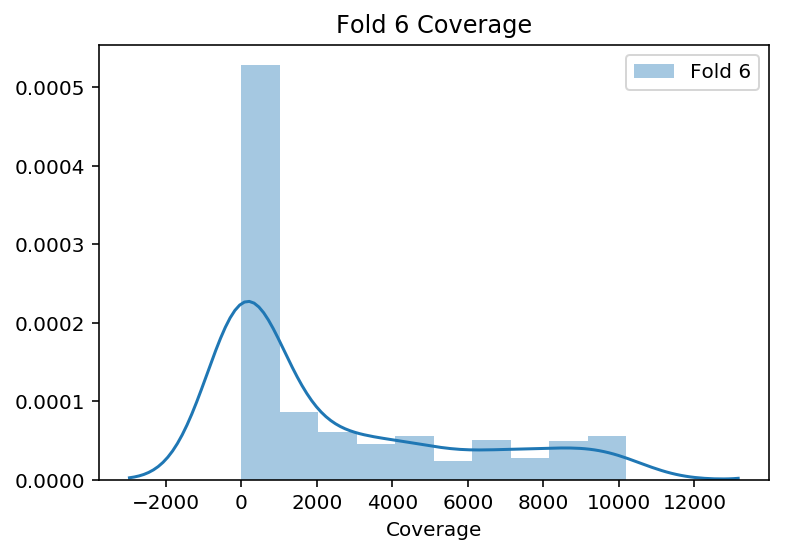

In [79]:
sns.distplot(f_six['cov'], label="Fold 6");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 6 Coverage");

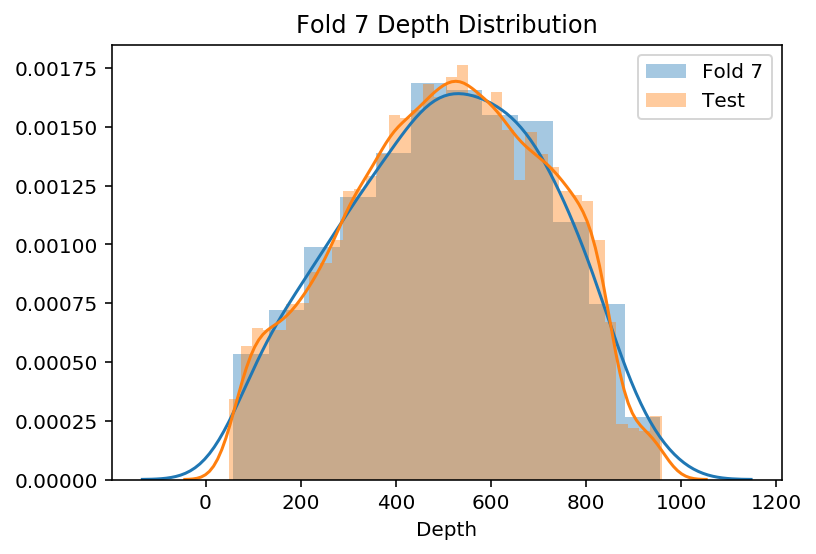

In [80]:
sns.distplot(f_seven['z'], label="Fold 7")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 7 Depth Distribution");

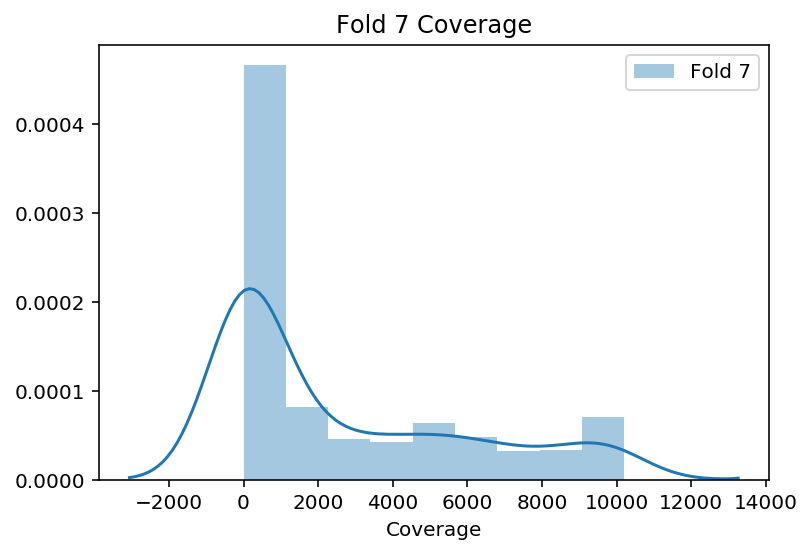

In [81]:
sns.distplot(f_seven['cov'], label="Fold 7");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 7 Coverage");

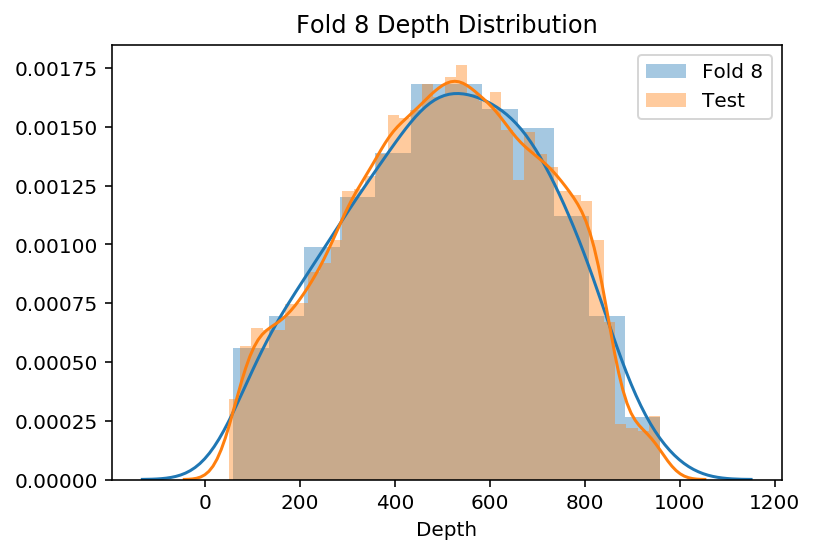

In [82]:
sns.distplot(f_eight['z'], label="Fold 8")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 8 Depth Distribution");

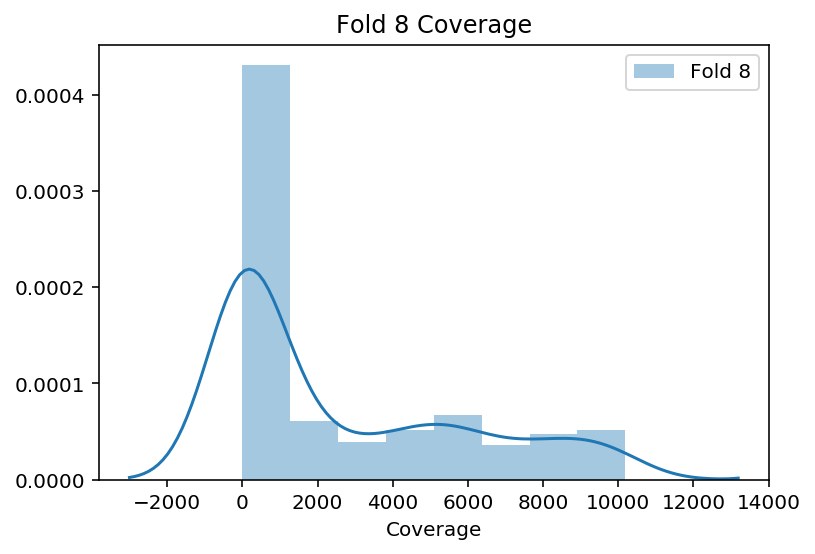

In [83]:
sns.distplot(f_eight['cov'], label="Fold 8");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 8 Coverage");

### Progressive Resizing Training

In [84]:
def train_64(train, val, arch):
    sz=64
    bs=128
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    lr=1e-2
    wd=1e-2
    lrs = np.array([lr/9,lr/3,lr])

    datasets = ImageData.get_ds(MatchedFilesDataset, train, val, tfms, test=(tst_x, tst_x), path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn = optim.Adam
    learn.metrics=[mean_avg_precision_IOU]
    # Cycle Lengths: 5, 5, 10, 20
    learn.crit=nn.BCEWithLogitsLoss()
    learn.freeze_to(1)
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp0')
    learn.load('64-tmp0')
    learn.crit=lovasz_loss
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp1')
    learn.load('64-tmp1')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp2')
    learn.load('64-tmp2')
    learn.crit=lovasz_loss
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs/2,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp-final')

In [85]:
def train_128(train, val, arch):
    sz=128
    bs=128
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    lr=1e-2
    wd=1e-2
    lrs = np.array([lr/9,lr/3,lr])

    datasets = ImageData.get_ds(MatchedFilesDataset, train, val, tfms, test=(tst_x, tst_x), path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn = optim.Adam
    learn.metrics=[mean_avg_precision_IOU]
    # Cycle Lengths: 5, 5, 10, 20
    learn.load('64-tmp-final')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.freeze_to(1)
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp0')
    learn.load('128-tmp0')
    learn.crit=lovasz_loss
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp1')
    learn.load('128-tmp1')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp2')
    learn.load('128-tmp2')
    learn.crit=lovasz_loss
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs/2,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp-final')

In [87]:
def train_256(train, val, arch, n_fold, name, n_snapshots, snapshots_dir, n_runs):
    sz=256
    bs=64
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    lr=1e-2
    wd=1e-2
    lrs = np.array([lr/9,lr/3,lr])

    datasets = ImageData.get_ds(MatchedFilesDataset, train, val, tfms, test=(tst_x, tst_x), path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn = optim.Adam
    learn.metrics=[mean_avg_precision_IOU]
    # Cycle Lengths: 5,5,10,30,30
    learn.load('128-tmp-final')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.freeze_to(1)
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp0')
    learn.load('256-tmp0')
    learn.crit=lovasz_loss
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp1')
    learn.load('256-tmp1')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp2')

    # N-Run training for final training cycle. Use SaveTopNModels() class
    # to get top 5 models across both runs combined.
    wd=7e-3
    best_models = []
    for i in range(n_runs):
        learn.load('256-tmp2')
        learn.crit=lovasz_loss
        learn.unfreeze()
        learn.bn_freeze(False)
        save_best_n = SaveTopNModels(learn, lrs, name, n_fold, snapshots_dir, n_saved=n_snapshots, run=i+1, final_run=(i==n_runs-1),best_models=best_models)
        learn.fit(lrs/2,1,wds=wd,use_wd_sched=True,cycle_len=30,use_clr=(20,30,0.95,0.85),callbacks=[save_best_n])
        best_models = save_best_n.best_models

    return learn, best_models

### N-Fold Validation Predictions

In [88]:
# From Vishnu: 
# https://github.com/svishnu88/TGS-SaltIdentification-Open-Solution-fastai/blob/master/Unet-Resnet34-Open%20Solution-FastAI.ipynb

class TestFilesDataset(FilesDataset):
    def __init__(self,fnames,y,transform,flip,path):
        self.y = y
        self.flip = flip
        super().__init__(fnames,transform,path)
        
    def get_x(self,i):
        im = open_image(os.path.join(self.path,self.fnames[i]))
        return np.fliplr(im) if self.flip else im
    
    def get_y(self, i):
        im = open_image(os.path.join(str(self.path), str(self.y[i])))
        return np.fliplr(im) if self.flip else im
    
    def get_c(self): return 0

In [89]:
def get_val_preds(train, val, arch, fold_models, n_snapshots, snapshots_path):
    sz=256
    bs=32
    val_preds = np.zeros(shape=(800,sz,sz))
    targs = np.zeros(shape=(800,sz,sz))
    for i in range(n_snapshots):
        model = fold_models[i]
        for o in [True,False]:   # TTA and Null
            tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
            datasets = ImageData.get_ds(TestFilesDataset, train, val, tfms, test=(tst_x, tst_x), flip=o, path=PATH)
            md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
            m_base = get_base()
            m = to_gpu(Unet34(m_base))
            models = UnetModel(m)
            learn = ConvLearner(md, models)
            learn.opt_fn = optim.Adam
            learn.crit=nn.BCEWithLogitsLoss()
            learn.metrics=[mean_avg_precision_IOU]
            learn.load(snapshots_path/model[0])
            learn.model.eval()

            preds, targs = learn.predict_with_targs(is_test=False)
            for im_idx, im in enumerate(preds):
                val_preds[im_idx] += np.fliplr(im) if o else im
            del preds
    # Divide val_preds by 2 to get avg of TTA, Null preds
    # Also divide by number of snapshots
    return val_preds/(n_snapshots*2), targs  

In [90]:
def get_final_val_score(preds, targs, thresh):
    scores = []
    for i in tqdm_notebook(range(len(preds))):
        scores.append(mean_avg_precision_IOU(preds[i], targs[i], thresh))
    return np.mean(scores)

In [91]:
def get_best_thresh(preds, targs):
    scores = []
    thresh = []
    for i in range(-50,51,1):
        t = i/100
        thresh.append(t)
        scores.append(mean_avg_precision_IOU(preds, targs, t))
    return thresh[np.argmax(scores)]

### N-Fold Training Loop

In [92]:
pipeline_strt = time.time()  # Start of training

In [93]:
# N run (Take best n best snapshot across n runs)

# Callback - get N best models
# Inspired by Ismaël Koné's SaveBestModel() class:
# http://forums.fast.ai/t/a-code-snippet-to-save-the-best-model-during-training/12066
from operator import itemgetter

class SaveTopNModels(LossRecorder):
    def __init__(self, learn, lr, name, fold, snapshots_dir, n_saved=2, run=1,final_run=False,best_models=[]):
        super().__init__(learn.get_layer_opt(lr,None))
        self.learn = learn
        self.name = name
        self.fold = fold
        self.snapshots_dir = snapshots_dir
        self.n_saved = n_saved
        self.run = run
        self.final_run = final_run
        self.best_models = best_models
        self.epoch_cnt = 0
        
    def on_epoch_end(self,metrics):
        super().on_epoch_end(metrics)
        iou_score = metrics[1]
        model_name = self.name + f'_fold_{self.fold}_run_{self.run}_epoch_{self.epoch_cnt}'
        if self.epoch_cnt>0 or len(self.best_models)>0: worst_score = min(self.best_models, key=itemgetter(1))[1]
        if len(self.best_models) < self.n_saved:  
            self.best_models.append((model_name,iou_score))
            self.learn.save(self.snapshots_dir/model_name)
        elif iou_score > worst_score:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            name_to_del = self.best_models[-1][0]
            del self.best_models[-1]
            os.remove(PATH/MODELS/self.snapshots_dir/f'{name_to_del}.h5')
            self.best_models.append((model_name,iou_score))
            self.learn.save(self.snapshots_dir/model_name)
        self.epoch_cnt += 1
    
    def on_train_end(self):
        if self.final_run:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            print(self.best_models)
            for i, item in enumerate(self.best_models):
                new_name = self.name + f'_fold_{self.fold}_snapshot_{i+1}'
                print(f'{item[0]}.h5')
                print(new_name)
                os.rename(PATH/MODELS/self.snapshots_dir/f'{item[0]}.h5', PATH/MODELS/self.snapshots_dir/f'{new_name}.h5')
                self.best_models[i] = (new_name, item[1])

In [94]:
N_FOLDS = 8
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [95]:
N_SNAPSHOTS = 10
SNAPSHOTS = Path('unet_resnet34/')
os.makedirs(PATH/MODELS/SNAPSHOTS, exist_ok=True)

In [96]:
all_models = []

for i in range(N_FOLDS):
    trn = train_df[train_df['fold'] != i]
    val = train_df[train_df['fold'] == i]
    trn_x = np.array(trn['im_path'])
    trn_y = np.array(trn['msk_path'])
    val_x = np.array(val['im_path'])
    val_y = np.array(val['msk_path'])
    ######
    print(f'############################################################################################')
    print(f'################################### Starting Fold {i+1} of {N_FOLDS} ###################################')
    print(f'############################################################################################\r')
    print('\r')
    ###### ######
    print(f'############ Size 64 ############ Now Training Fold {i+1} of {N_FOLDS} ############ Size 64 ############')
    train_64((trn_x,trn_y), (val_x,val_y), ARCH)
    print('\r')
    print('\r')
    print(f'############ Size 128 ########### Now Training Fold {i+1} of {N_FOLDS} ########### Size 128 ############')
    train_128((trn_x,trn_y), (val_x,val_y), ARCH)
    print('\r')
    print('\r')
    print(f'############ Size 256 ########### Now Training Fold {i+1} of {N_FOLDS} ########### Size 256 ############')
    learn, top_models = train_256((trn_x,trn_y), (val_x,val_y), ARCH, i+1, MODEL_NAME, N_SNAPSHOTS, SNAPSHOTS, 3) # Run final training round 3 times.
    all_models.append(top_models)
    print('\r')
    print('\r')

############################################################################################
################################### Starting Fold 1 of 8 ###################################
############################################################################################

############ Size 64 ############ Now Training Fold 1 of 8 ############ Size 64 ############


epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.333034   0.469487   0.575     
    1      0.246474   0.197886   0.6438                    
    2      0.202183   0.160041   0.665                     
    3      0.170613   0.14222    0.679                     
    4      0.147078   0.141397   0.671                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.56191    0.608256   0.6432    
    1      0.497993   0.496608   0.7004                    
    2      0.447231   0.47237    0.713                     
    3      0.41195    0.457381   0.7168                    
    4      0.388004   0.472165   0.7208                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.191957   0.21262    0.6058    
    1      0.163569   0.218955   0.6766                    
    2      0.151795   0.167649   0.693                     
    3      0.133944   0.16811    0.7062                    
    4      0.119456   0.181285   0.6802                    
    5      0.109433   0.152877   0.7182                    
    6      0.095885   0.155785   0.7166                     
    7      0.085539   0.153842   0.6866                     
    8      0.07557    0.154891   0.7186                     
    9      0.067661   0.154561   0.7176                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.368101   0.500275   0.718     
    1      0.328726   0.492626   0.7192                    
    2      0.309315   0.47272    0.7322                    
    3      0.297318   0.437728   0.7332                    
    4      0.284227   0.465716   0.7304                    
    5      0.274878   0.448618   0.7302                    
    6      0.269515   0.438353   0.7326                    
    7      0.263073   0.416715   0.7452                    
    8      0.258459   0.435815   0.7402                    
    9      0.250843   0.413795   0.7502                    
    10     0.238882   0.407149   0.7576                    
    11     0.229565   0.396756   0.756                     
    12     0.219661   0.414101   0.7528                    
    13     0.21562    0.396839   0.7652                    
    14     0.208511   0.403988   0.7528                    
    15     0.205605   0.406978   0.7548                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.188299   0.344421   0.5618    
    1      0.164694   0.138938   0.6932                    
    2      0.144732   0.150935   0.7138                    
    3      0.129331   0.134363   0.7116                    
    4      0.115674   0.127068   0.7216                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.445234   0.450456   0.7398    
    1      0.401867   0.467267   0.7272                    
    2      0.369004   0.428678   0.7502                    
    3      0.345698   0.384945   0.7606                    
    4      0.32484    0.389521   0.7654                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.170695   0.43007    0.5116    
    1      0.145527   0.158861   0.6988                    
    2      0.136009   0.157501   0.7166                    
    3      0.121297   0.127435   0.7388                    
    4      0.111853   0.129492   0.7336                    
    5      0.102343   0.12474    0.7482                    
    6      0.091415   0.140101   0.7388                     
    7      0.08093    0.11635    0.761                      
    8      0.071682   0.140874   0.7528                     
    9      0.063906   0.14176    0.7594                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.34423    0.420343   0.7496    
    1      0.300896   0.417178   0.749                     
    2      0.283395   0.389568   0.763                     
    3      0.272217   0.372178   0.7748                    
    4      0.266279   0.414062   0.7554                    
    5      0.255573   0.389394   0.767                     
    6      0.245985   0.377758   0.7712                    
    7      0.248711   0.381558   0.7602                    
    8      0.239864   0.381169   0.7656                    
    9      0.229015   0.348233   0.7774                    
    10     0.223952   0.341489   0.7804                    
    11     0.218957   0.359347   0.7674                    
    12     0.210965   0.335314   0.787                     
    13     0.203783   0.357165   0.7798                    
    14     0.197364   0.33505    0.7824                    
    15     0.192068   0.347417   0.7858                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.186996   0.157746   0.6618    
    1      0.159725   0.159004   0.7128                    
    2      0.142786   0.144236   0.7234                    
    3      0.126742   0.125257   0.7172                    
    4      0.110465   0.125304   0.7274                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.420866   0.418067   0.7548    
    1      0.39808    0.416097   0.742                     
    2      0.371402   0.410185   0.7578                    
    3      0.345944   0.380686   0.7538                    
    4      0.315352   0.377588   0.762                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.182955   0.189432   0.6358    
    1      0.160739   0.144665   0.7198                    
    2      0.135652   0.124169   0.7406                    
    3      0.127289   0.133151   0.7432                    
    4      0.122189   0.131683   0.7078                    
    5      0.110095   0.120751   0.7596                    
    6      0.093292   0.112541   0.75                       
    7      0.082246   0.116945   0.7682                     
    8      0.075098   0.118874   0.7674                     
    9      0.062996   0.107644   0.7758                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.358047   0.398598   0.771     
    1      0.301182   0.382627   0.769                     
    2      0.274652   0.384488   0.7754                    
    3      0.263871   0.3743     0.7792                    
    4      0.261242   0.36579    0.7762                    
    5      0.258789   0.362402   0.7698                    
    6      0.243334   0.346534   0.786                     
    7      0.237092   0.361562   0.774                     
    8      0.231422   0.335692   0.782                     
    9      0.237161   0.364219   0.7692                    
    10     0.24013    0.345766   0.7834                    
    11     0.231383   0.333234   0.784                     
    12     0.217674   0.308949   0.7912                    
    13     0.213718   0.324769   0.7952                    
    14     0.211545   0.344377   0.7816                    
    15     0.212803   0.325589   0.7936                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.342195   0.434483   0.7642    
    1      0.301451   0.386357   0.771                     
    2      0.273525   0.387401   0.7746                    
    3      0.268967   0.355801   0.7816                    
    4      0.260638   0.36507    0.7744                    
    5      0.242722   0.35085    0.7772                    
    6      0.249963   0.372167   0.7752                    
    7      0.246748   0.354561   0.7766                    
    8      0.237023   0.349589   0.7742                    
    9      0.234114   0.359275   0.7664                    
    10     0.228844   0.377277   0.7672                    
    11     0.233183   0.345899   0.7896                    
    12     0.235292   0.352984   0.782                     
    13     0.231219   0.337956   0.7764                    
    14     0.221242   0.31834    0.7948                    
    15     0.207834   0.339833   0.7832                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.355203   0.422979   0.7648    
    1      0.305048   0.358921   0.781                     
    2      0.270999   0.339478   0.7908                    
    3      0.276428   0.410664   0.7574                    
    4      0.274068   0.389336   0.759                     
    5      0.260309   0.344775   0.7912                    
    6      0.269949   0.366812   0.7722                    
    7      0.256893   0.39363    0.76                      
    8      0.243706   0.330492   0.7914                    
    9      0.232707   0.334143   0.788                     
    10     0.225065   0.348681   0.7786                    
    11     0.228003   0.336632   0.7924                    
    12     0.219083   0.33972    0.7922                    
    13     0.215386   0.368831   0.766                     
    14     0.218695   0.35055    0.7762                    
    15     0.205554   0.323247   0.797                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.330187   0.68542    0.5406    
    1      0.245194   0.153684   0.6822                    
    2      0.203106   0.147939   0.688                     
    3      0.172972   0.142962   0.6914                    
    4      0.150388   0.118338   0.722                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.557185   0.453577   0.7202    
    1      0.493577   0.43397    0.732                     
    2      0.45324    0.392089   0.7508                    
    3      0.421695   0.365971   0.767                     
    4      0.390745   0.342368   0.779                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.221333   0.232559   0.6484    
    1      0.182334   0.190478   0.666                     
    2      0.155522   0.119755   0.7438                    
    3      0.134449   0.154296   0.7398                    
    4      0.12314    0.122161   0.77                      
    5      0.107073   0.109474   0.7696                    
    6      0.095261   0.118105   0.785                      
    7      0.085827   0.099888   0.783                      
    8      0.075284   0.104221   0.7838                     
    9      0.068446   0.101646   0.7898                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.365655   0.354442   0.789     
    1      0.339532   0.35778    0.7874                    
    2      0.319527   0.338154   0.7956                    
    3      0.307395   0.326207   0.795                     
    4      0.289519   0.335226   0.7864                    
    5      0.27325    0.338393   0.798                     
    6      0.264726   0.312189   0.801                     
    7      0.257818   0.30294    0.7996                    
    8      0.248103   0.312747   0.798                     
    9      0.242789   0.316024   0.8112                    
    10     0.234101   0.285986   0.8114                    
    11     0.223727   0.306708   0.8026                    
    12     0.214261   0.29142    0.8072                    
    13     0.207856   0.294506   0.808                     
    14     0.20353    0.288385   0.8092                    
    15     0.194982   0.290048   0.8082                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.194241   0.16811    0.6802    
    1      0.161829   0.11234    0.7314                    
    2      0.144516   0.106783   0.7828                    
    3      0.127185   0.089668   0.7834                    
    4      0.115884   0.090301   0.7858                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.430058   0.331594   0.799     
    1      0.394453   0.324441   0.8024                    
    2      0.365961   0.296028   0.8182                    
    3      0.337585   0.294974   0.8138                    
    4      0.311445   0.280553   0.8114                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.174028   0.151541   0.7176    
    1      0.152446   0.133745   0.708                     
    2      0.138862   0.104471   0.7772                    
    3      0.121609   0.103835   0.7728                    
    4      0.106585   0.097913   0.782                     
    5      0.095215   0.096943   0.8144                     
    6      0.086262   0.094859   0.7844                     
    7      0.078064   0.087589   0.8116                     
    8      0.068708   0.08547    0.8124                     
    9      0.061423   0.083704   0.8178                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.341044   0.307317   0.8224    
    1      0.293161   0.30728    0.8142                    
    2      0.271343   0.297033   0.8166                    
    3      0.256346   0.297945   0.817                     
    4      0.24835    0.271116   0.8272                    
    5      0.241447   0.277902   0.8234                    
    6      0.236889   0.270347   0.8314                    
    7      0.231005   0.286248   0.82                      
    8      0.220844   0.265831   0.8312                    
    9      0.214151   0.264158   0.8308                    
    10     0.207249   0.275282   0.8224                    
    11     0.20057    0.252817   0.8324                    
    12     0.193253   0.252969   0.8372                    
    13     0.188472   0.249199   0.8366                    
    1      0.160494   0.107928   0.7534                    
    2      0.142804   0.107846   0.7788                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.441788   0.350089   0.7862    
    1      0.390137   0.33967    0.7934                    
    2      0.370681   0.326557   0.803                     
    3      0.338887   0.280596   0.8202                    
    4      0.315629   0.27755    0.8308                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.191783   0.112719   0.7544    
    1      0.155664   0.120884   0.7852                    
    2      0.139917   0.134938   0.7466                    
    3      0.128688   0.088851   0.7972                    
    4      0.115979   0.106372   0.7868                    
    5      0.103107   0.091683   0.7958                    
    6      0.095028   0.088616   0.7988                     
    7      0.083883   0.102918   0.8106                     
    8      0.075844   0.089563   0.8076                     
    9      0.065723   0.084928   0.817                      



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.344934   0.346018   0.8202    
    1      0.312793   0.300909   0.8214                    
    2      0.282528   0.316849   0.807                     
    3      0.267951   0.312994   0.8174                    
    4      0.270201   0.286583   0.8256                    
    5      0.255017   0.279981   0.826                     
    6      0.245904   0.272175   0.8314                    
    7      0.238449   0.292202   0.8254                    
    8      0.232515   0.281297   0.827                     
    9      0.224083   0.282914   0.8156                    
    10     0.226037   0.29803    0.8184                    
    11     0.223607   0.283293   0.82                      
    12     0.216809   0.285776   0.8232                    
    13     0.202273   0.260058   0.8362                    
    14     0.197639   0.284024   0.8266                    
    15     0.196559   0.267805   0.8382                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.35007    0.324486   0.8238    
    1      0.301969   0.292089   0.83                      
    2      0.280039   0.294831   0.8238                    
    3      0.278058   0.276674   0.8284                    
    4      0.265128   0.270768   0.8356                    
    5      0.262698   0.286312   0.8228                    
    6      0.254169   0.293291   0.823                     
    7      0.253506   0.270816   0.8308                    
    8      0.239985   0.266864   0.8308                    
    9      0.236632   0.295361   0.8194                    
    10     0.228194   0.324183   0.797                     
    11     0.221474   0.262468   0.832                     
    12     0.211053   0.257482   0.8374                    
    13     0.201621   0.255763   0.8384                    
    14     0.198552   0.268584   0.8348                    
    15     0.201834   0.268041   0.8308                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.362272   0.330934   0.819     
    1      0.31249    0.309528   0.8254                    
    2      0.284788   0.323579   0.811                     
    3      0.269455   0.271854   0.8364                    
    4      0.262535   0.285223   0.825                     
    5      0.253458   0.311856   0.8058                    
    6      0.250141   0.300957   0.8154                    
    7      0.243937   0.277886   0.825                     
    8      0.236528   0.269516   0.8356                    
    9      0.223715   0.276744   0.8284                    
    10     0.226793   0.262523   0.8332                    
    11     0.219293   0.265115   0.8306                    
    12     0.210658   0.267346   0.8346                    
    13     0.20644    0.260798   0.8378                    
    14     0.200359   0.255461   0.8342                    
    15     0.201142   0.252037   0.8412                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.315426   0.523334   0.5558    
    1      0.230092   0.22083    0.607                     
    2      0.186698   0.202815   0.6464                    
    3      0.161645   0.176881   0.6608                    
    4      0.138823   0.16748    0.6684                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.553311   0.546371   0.6564    
    1      0.488233   0.518613   0.681                     
    2      0.433776   0.466967   0.6916                    
    3      0.3986     0.453927   0.6998                    
    4      0.368713   0.456032   0.709                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.210499   0.339282   0.6124    
    1      0.190711   0.201419   0.675                     
    2      0.162398   0.16686    0.6732                    
    3      0.14167    0.187207   0.6558                    
    4      0.125965   0.184313   0.6982                    
    5      0.113251   0.144472   0.7054                    
    6      0.100414   0.14885    0.702                     
    7      0.087051   0.162308   0.7218                     
    8      0.07515    0.171767   0.724                      
    9      0.06741    0.172389   0.7146                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.375709   0.491867   0.7228    
    1      0.336553   0.448945   0.7246                    
    2      0.308389   0.440831   0.7296                    
    3      0.286195   0.443339   0.7254                    
    4      0.274626   0.432469   0.7314                    
    5      0.264131   0.447996   0.7174                    
    6      0.257428   0.479194   0.7098                    
    7      0.249061   0.406519   0.7426                    
    8      0.246665   0.437605   0.7136                    
    9      0.244867   0.411373   0.7464                    
    10     0.239278   0.408572   0.7366                    
    11     0.231287   0.394241   0.7466                    
    12     0.221759   0.391298   0.7404                    
    13     0.213369   0.384593   0.7424                    
    14     0.208747   0.405389   0.748                     
    15     0.199997   0.402252   0.7436                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.191919   0.187245   0.6012    
    1      0.160606   0.163488   0.7152                    
    2      0.142109   0.165925   0.7188                    
    3      0.130163   0.138078   0.7362                    
    4      0.114753   0.131933   0.7452                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.433359   0.557686   0.6998    
    1      0.399733   0.408416   0.751                     
    2      0.36811    0.387835   0.7454                    
    3      0.344682   0.369978   0.7564                    
    4      0.32221    0.340934   0.7752                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.173617   0.185788   0.686     
    1      0.154873   0.175702   0.7036                    
    2      0.136805   0.145195   0.7432                    
    3      0.1294     0.150325   0.7142                    
    4      0.11495    0.15355    0.75                      
    5      0.10525    0.14165    0.7318                    
    6      0.092881   0.133635   0.7618                     
    7      0.081686   0.132604   0.7724                     
    8      0.070265   0.115361   0.78                       
    9      0.062728   0.116551   0.7852                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.335456   0.468034   0.7394    
    1      0.294114   0.366931   0.778                     
    2      0.273296   0.357402   0.7828                    
    3      0.257471   0.368568   0.775                     
    4      0.253345   0.34106    0.7864                    
    5      0.252338   0.388267   0.7614                    
    6      0.244319   0.341277   0.7828                    
    7      0.231385   0.333656   0.7916                    
    8      0.220015   0.332055   0.7888                    
    9      0.209383   0.315731   0.7958                    
    10     0.204895   0.322044   0.7888                    
    11     0.197722   0.314684   0.7924                    
    12     0.194795   0.326262   0.7872                    
    13     0.18965    0.319369   0.7954                    
    14     0.183893   0.313611   0.7988                    
    15     0.178429   0.306947   0.794                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.188083   0.159782   0.6692    
    1      0.153752   0.144541   0.6978                    
    2      0.143012   0.137805   0.7304                    
    3      0.125068   0.130796   0.7326                    
    4      0.11034    0.130351   0.7444                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.435029   0.487065   0.7146    
    1      0.397015   0.395703   0.7506                    
    2      0.364899   0.370455   0.7654                    
    3      0.336106   0.351846   0.7592                    
    4      0.30844    0.334483   0.7778                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.176888   0.171125   0.6942    
    1      0.147598   0.160359   0.6982                    
    2      0.135188   0.141048   0.7432                    
    3      0.125414   0.150795   0.7416                    
    4      0.110472   0.145794   0.7396                    
    5      0.101743   0.136575   0.7492                    
    6      0.088472   0.11492    0.7656                     
    7      0.080536   0.118087   0.7788                     
    8      0.074367   0.120043   0.7826                     
    9      0.064803   0.109268   0.7816                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.352993   0.367763   0.787     
    1      0.302107   0.361824   0.7844                    
    2      0.279672   0.334876   0.785                     
    3      0.278867   0.3532     0.7786                    
    4      0.266242   0.365632   0.7628                    
    5      0.265414   0.371077   0.774                     
    6      0.255468   0.343801   0.7804                    
    7      0.24975    0.349075   0.7784                    
    8      0.24333    0.319308   0.7964                    
    9      0.231732   0.318719   0.7916                    
    10     0.226822   0.304022   0.7998                    
    11     0.230732   0.311611   0.7922                    
    12     0.226351   0.330162   0.788                     
    13     0.223037   0.304508   0.8016                    
    14     0.209138   0.310646   0.799                     
    15     0.207008   0.32091    0.7836                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.355291   0.361652   0.7892    
    1      0.29683    0.343955   0.7908                    
    2      0.273204   0.328597   0.7924                    
    3      0.272065   0.317355   0.7932                    
    4      0.25868    0.322479   0.7968                    
    5      0.248219   0.329538   0.7896                    
    6      0.243707   0.315942   0.796                     
    7      0.2359     0.324082   0.7906                    
    8      0.244911   0.334573   0.7866                    
    9      0.25275    0.315271   0.7892                    
    10     0.238843   0.333485   0.7892                    
    11     0.240256   0.339479   0.785                     
    12     0.224429   0.314503   0.7944                    
    13     0.21714    0.315341   0.7956                    
    14     0.209079   0.336646   0.7782                    
    15     0.206796   0.315955   0.7952                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.340314   0.375112   0.7824    
    1      0.294359   0.361206   0.7862                    
    2      0.276424   0.3399     0.7852                    
    3      0.261719   0.364496   0.7708                    
    4      0.271248   0.323638   0.7864                    
    5      0.288521   0.443481   0.7266                    
    6      0.274688   0.370204   0.7576                    
    7      0.263294   0.317963   0.783                     
    8      0.252121   0.339411   0.7874                    
    9      0.249774   0.33578    0.7794                    
    10     0.239904   0.30597    0.8014                    
    11     0.227777   0.318885   0.7906                    
    12     0.225296   0.317674   0.7878                    
    13     0.218381   0.301449   0.7966                    
    14     0.213651   0.284128   0.8032                    
    15     0.217769   0.317604   0.791                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.318832   7.699842   0.0932    
    1      0.234686   0.229426   0.6544                    
    2      0.193119   0.188068   0.6336                    
    3      0.164477   0.176703   0.66                      
    4      0.141911   0.168349   0.673                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.54331    0.573544   0.6588    
    1      0.494071   0.497679   0.6808                    
    2      0.469105   0.448382   0.72                      
    3      0.432438   0.425688   0.7228                    
    4      0.397951   0.414771   0.7336                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.21899    0.340875   0.4826    
    1      0.193795   0.174123   0.6866                    
    2      0.167826   0.157671   0.7028                    
    3      0.148948   0.151544   0.7236                    
    4      0.1314     0.163244   0.7138                    
    5      0.116213   0.142812   0.7254                    
    6      0.10393    0.152284   0.7234                    
    7      0.094015   0.165234   0.737                      
    8      0.083078   0.16299    0.7318                     
    9      0.073823   0.163733   0.7382                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.393148   0.459341   0.7378    
    1      0.36247    0.494445   0.7214                    
    2      0.33304    0.461027   0.7294                    
    3      0.316169   0.425264   0.7552                    
    4      0.302802   0.51198    0.7228                    
    5      0.298451   0.418429   0.7518                    
    6      0.288073   0.432386   0.7386                    
    7      0.279327   0.411508   0.7446                    
    8      0.270796   0.389013   0.7582                    
    9      0.262878   0.390353   0.7508                    
    10     0.252426   0.389415   0.7522                    
    11     0.24337    0.385436   0.7596                    
    12     0.232972   0.386263   0.7564                    
    13     0.223822   0.375055   0.7554                    
    14     0.216587   0.377254   0.759                     
    15     0.209107   0.387631   0.7598                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.202783   0.189446   0.615     
    1      0.166884   0.150052   0.695                     
    2      0.149342   0.143531   0.72                      
    3      0.129947   0.144014   0.722                     
    4      0.117008   0.134316   0.7522                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.455731   0.43265    0.737     
    1      0.402366   0.429152   0.7448                    
    2      0.378314   0.381972   0.7522                    
    3      0.355281   0.351369   0.7754                    
    4      0.331565   0.380967   0.7468                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.175312   0.243632   0.6818    
    1      0.157317   0.194652   0.719                     
    2      0.145668   0.156828   0.7328                    
    3      0.130219   0.154575   0.7278                    
    4      0.121091   0.151629   0.7556                    
    5      0.111568   0.123207   0.7612                    
    6      0.103528   0.142123   0.7478                    
    7      0.090829   0.128088   0.765                      
    8      0.081633   0.139246   0.7592                     
    9      0.071484   0.137807   0.7664                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.358501   0.426764   0.7648    
    1      0.319143   0.352965   0.7908                    
    2      0.297508   0.354472   0.7838                    
    3      0.279114   0.341488   0.7792                    
    4      0.267093   0.356911   0.7858                    
    5      0.262233   0.358232   0.778                     
    6      0.257529   0.383269   0.757                     
    7      0.248775   0.349809   0.7854                    
    8      0.247938   0.34903    0.7872                    
    9      0.239725   0.350798   0.7806                    
    10     0.233403   0.341964   0.7984                    
    11     0.222201   0.35198    0.7796                    
    12     0.215652   0.306121   0.8044                    
    13     0.208953   0.336806   0.7924                    
    14     0.202649   0.311284   0.8014                    
    15     0.201876   0.323084   0.8016                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.201959   0.165823   0.6736    
    1      0.170734   0.162253   0.677                     
    2      0.149635   0.157268   0.7302                    
    3      0.132722   0.138619   0.7538                    
    4      0.12191    0.13439    0.7432                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.440044   0.449415   0.7318    
    1      0.405777   0.402645   0.7608                    
    2      0.391344   0.37235    0.7694                    
    3      0.359376   0.343755   0.7848                    
    4      0.335049   0.343616   0.7816                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.192565   0.199275   0.702     
    1      0.172459   0.151666   0.7308                    
    2      0.145253   0.142589   0.7574                    
    3      0.134069   0.158062   0.728                     
    4      0.121343   0.129764   0.7492                    
    5      0.107736   0.152747   0.7368                    
    6      0.10486    0.134154   0.7484                    
    7      0.098751   0.148513   0.74                       
    8      0.087837   0.124468   0.7746                     
    9      0.075201   0.119879   0.7784                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.371464   0.373125   0.7942    
    1      0.320148   0.335764   0.7932                    
    2      0.282074   0.398795   0.7734                    
    3      0.279166   0.322424   0.8018                    
    4      0.273045   0.340719   0.7902                    
    5      0.26535    0.3683     0.7728                    
    6      0.270999   0.35163    0.7908                    
    7      0.253506   0.334358   0.7954                    
    8      0.240806   0.298816   0.8098                    
    9      0.237389   0.305754   0.8092                    
    10     0.232044   0.34065    0.7824                    
    11     0.227811   0.319712   0.7994                    
    12     0.230749   0.309354   0.7992                    
    13     0.232396   0.334084   0.7906                    
    14     0.231789   0.351117   0.7782                    
    15     0.258346   0.32725    0.7976                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.366815   0.383958   0.7902    
    1      0.312421   0.352332   0.7924                    
    2      0.284259   0.323968   0.8006                    
    3      0.304252   0.375344   0.7764                    
    4      0.288633   0.331108   0.7952                    
    5      0.268629   0.361551   0.7838                    
    6      0.258662   0.334581   0.797                     
    7      0.268563   0.356958   0.7836                    
    8      0.247235   0.327306   0.8022                    
    9      0.24431    0.352632   0.7838                    
    10     0.235187   0.335852   0.7982                    
    11     0.231985   0.349396   0.7862                    
    12     0.232773   0.310838   0.8044                    
    13     0.221319   0.29832    0.8072                    
    14     0.222275   0.310688   0.8018                    
    15     0.220264   0.322208   0.805                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.35226    0.369854   0.7946    
    1      0.311541   0.341435   0.7992                    
    2      0.289268   0.343508   0.79                      
    3      0.282417   0.347693   0.7964                    
    4      0.274495   0.342524   0.7916                    
    5      0.279452   0.351579   0.7856                    
    6      0.281877   0.320774   0.7952                    
    7      0.272387   0.364072   0.774                     
    8      0.257326   0.32127    0.7984                    
    9      0.241765   0.332187   0.7932                    
    10     0.238797   0.330296   0.8                       
    11     0.248378   0.359084   0.7852                    
    12     0.228625   0.317924   0.8022                    
    13     0.219135   0.310942   0.8026                    
    14     0.217635   0.296436   0.8102                    
    15     0.213556   0.317212   0.8016                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.321807   0.475073   0.5326    
    1      0.238591   0.211759   0.6268                    
    2      0.194517   0.197195   0.6452                    
    3      0.164948   0.198309   0.6726                    
    4      0.14331    0.180575   0.6722                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.570637   0.547493   0.6956    
    1      0.499826   0.518061   0.6948                    
    2      0.45982    0.513639   0.694                     
    3      0.421511   0.46       0.717                     
    4      0.394087   0.45366    0.7162                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.193249   0.286978   0.6026    
    1      0.170647   0.259184   0.6584                    
    2      0.147421   0.18781    0.6832                    
    3      0.132288   0.188278   0.7048                    
    4      0.116503   0.222811   0.702                     
    5      0.106398   0.185412   0.7384                    
    6      0.093681   0.195907   0.7424                     
    7      0.084669   0.200706   0.7422                     
    8      0.07932    0.192948   0.7346                     
    9      0.071303   0.195828   0.7338                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.388258   0.490292   0.7412    
    1      0.345004   0.437158   0.7458                    
    2      0.319589   0.437756   0.748                     
    3      0.301631   0.456816   0.7418                    
    4      0.295796   0.461333   0.745                     
    5      0.295541   0.48102    0.7212                    
    6      0.298032   0.440957   0.7414                    
    7      0.295567   0.443381   0.7316                    
    8      0.287923   0.413559   0.752                     
    9      0.27778    0.398631   0.7586                    
    10     0.263221   0.391557   0.7586                    
    11     0.251385   0.414749   0.748                     
    12     0.239351   0.376988   0.7706                    
    13     0.229426   0.391907   0.7624                    
    14     0.226698   0.395239   0.7612                    
    15     0.220133   0.376371   0.7638                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.190359   0.229799   0.6744    
    1      0.165506   0.163398   0.7118                    
    2      0.148011   0.17506    0.7284                    
    3      0.13215    0.167208   0.7326                    
    4      0.119289   0.163831   0.7266                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.443362   0.450008   0.7436    
    1      0.396341   0.415008   0.754                     
    2      0.362055   0.422953   0.7462                    
    3      0.34408    0.402799   0.7458                    
    4      0.324187   0.369065   0.7712                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.178714   0.239557   0.6638    
    1      0.151139   0.19762    0.6836                    
    2      0.131656   0.184964   0.736                     
    3      0.113259   0.206619   0.7252                    
    4      0.10182    0.151735   0.744                     
    5      0.090972   0.173983   0.745                      
    6      0.082214   0.172791   0.7548                     
    7      0.074629   0.182403   0.7734                     
    8      0.065762   0.189416   0.768                      
    9      0.058901   0.184755   0.7726                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.364641   0.449205   0.772     
    1      0.31035    0.39769    0.7766                    
    2      0.276872   0.375604   0.7886                    
    3      0.260251   0.410779   0.7668                    
    4      0.252403   0.383898   0.7766                    
    5      0.25305    0.395555   0.7686                    
    6      0.248994   0.379799   0.7748                    
    7      0.240387   0.368627   0.7838                    
    8      0.228908   0.349843   0.788                     
    9      0.221629   0.336246   0.7986                    
    10     0.215318   0.33946    0.7944                    
    11     0.211432   0.344831   0.7874                    
    12     0.205343   0.335685   0.7954                    
    13     0.200864   0.332578   0.7912                    
    14     0.197666   0.327172   0.7982                    
    15     0.191659   0.34022    0.7902                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.18755    0.195714   0.715     
    1      0.160538   0.187094   0.6788                    
    2      0.143037   0.15755    0.7286                    
    3      0.12674    0.151306   0.7368                    
    4      0.113898   0.157402   0.751                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.432007   0.424971   0.754     
    1      0.398316   0.414986   0.7408                    
    2      0.372898   0.381462   0.7674                    
    3      0.338765   0.368925   0.7786                    
    4      0.314071   0.354819   0.7776                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.192911   0.255579   0.639     
    1      0.160157   0.19974    0.7114                    
    2      0.140436   0.162984   0.7478                    
    3      0.128726   0.168101   0.7176                    
    4      0.116824   0.151902   0.7508                    
    5      0.105033   0.171408   0.7456                    
    6      0.094984   0.141904   0.757                      
    7      0.083082   0.163377   0.7974                     
    8      0.074839   0.156207   0.786                      
    9      0.06609    0.16647    0.7962                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.363207   0.418545   0.7824    
    1      0.313399   0.381043   0.7868                    
    2      0.301933   0.398835   0.7704                    
    3      0.276773   0.351995   0.7896                    
    4      0.27128    0.376882   0.7794                    
    5      0.268503   0.360819   0.7746                    
    6      0.274495   0.344384   0.7892                    
    7      0.261251   0.357245   0.7826                    
    8      0.252862   0.387115   0.7744                    
    9      0.249814   0.339995   0.7886                    
    10     0.266093   0.338442   0.7862                    
    11     0.251011   0.355009   0.7916                    
    12     0.239254   0.360219   0.784                     
    13     0.232457   0.33787    0.7962                    
    14     0.228737   0.357992   0.785                     
    15     0.216853   0.328927   0.7948                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.357856   0.398094   0.7952    
    1      0.307071   0.374503   0.7928                    
    2      0.298772   0.396369   0.7718                    
    3      0.288823   0.363444   0.7846                    
    4      0.272676   0.354414   0.7818                    
    5      0.276606   0.344491   0.7896                    
    6      0.261112   0.353724   0.78                      
    7      0.254369   0.361292   0.7886                    
    8      0.257368   0.345353   0.7796                    
    9      0.238455   0.339744   0.794                     
    10     0.267205   0.345813   0.789                     
    11     0.253691   0.332825   0.7984                    
    12     0.241443   0.341718   0.793                     
    13     0.231007   0.326959   0.8014                    
    14     0.229137   0.338561   0.785                     
    15     0.227091   0.338239   0.787                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.361851   0.399146   0.7802    
    1      0.305635   0.375838   0.789                     
    2      0.289696   0.36703    0.7874                    
    3      0.277457   0.35181    0.7898                    
    4      0.27275    0.364936   0.7888                    
    5      0.261924   0.351343   0.7886                    
    6      0.254317   0.378162   0.7748                    
    7      0.248175   0.353735   0.7814                    
    8      0.254603   0.360827   0.777                     
    9      0.250458   0.340184   0.7836                    
    10     0.240214   0.331635   0.7996                    
    11     0.233549   0.341331   0.7892                    
    12     0.228266   0.340356   0.7942                    
    13     0.218298   0.334517   0.8006                    
    14     0.209224   0.31179    0.8078                    
    15     0.206474   0.33099    0.797                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.318431   0.562519   0.5906    
    1      0.23203    0.207426   0.6274                    
    2      0.194157   0.178892   0.6592                    
    3      0.168599   0.155958   0.681                     
    4      0.149571   0.148859   0.6832                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.546952   0.984238   0.6212    
    1      0.482566   0.480587   0.695                     
    2      0.440808   0.449699   0.699                     
    3      0.407632   0.420569   0.715                     
    4      0.378306   0.414543   0.7206                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.196007   0.294591   0.6328    
    1      0.181006   0.207683   0.6428                    
    2      0.160131   0.170222   0.701                     
    3      0.137483   0.172871   0.686                     
    4      0.124192   0.148247   0.7152                    
    5      0.110812   0.149254   0.7246                    
    6      0.10032    0.15527    0.7212                     
    7      0.089513   0.159263   0.7244                     
    8      0.079225   0.137865   0.7248                     
    9      0.072155   0.142684   0.7406                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.404106   0.448071   0.7316    
    1      0.354288   0.437165   0.7402                    
    2      0.317777   0.399341   0.7428                    
    3      0.300706   0.402116   0.7488                    
    4      0.284641   0.406622   0.7442                    
    5      0.274219   0.39489    0.7554                    
    6      0.269008   0.390682   0.749                     
    7      0.266148   0.387986   0.7504                    
    8      0.252397   0.387085   0.7412                    
    9      0.239809   0.396048   0.7594                    
    10     0.227869   0.370009   0.7564                    
    11     0.218937   0.382059   0.7516                    
    12     0.212541   0.357562   0.7628                    
    13     0.206647   0.374672   0.7494                    
    14     0.201402   0.367166   0.7556                    
    15     0.193333   0.378492   0.7518                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.198779   0.223015   0.5926    
    1      0.163502   0.136217   0.7306                    
    2      0.145511   0.140772   0.724                     
    3      0.129765   0.126861   0.7438                    
    4      0.119188   0.137598   0.736                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.443361   0.628748   0.7012    
    1      0.392129   0.385884   0.7602                    
    2      0.360117   0.38618    0.7664                    
    3      0.341295   0.385697   0.773                     
    4      0.323035   0.350076   0.7774                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.179357   0.186955   0.6564    
    1      0.167814   0.177472   0.6988                    
    2      0.147766   0.143275   0.7592                    
    3      0.134998   0.155708   0.7224                    
    4      0.120329   0.134753   0.7576                    
    5      0.108957   0.126735   0.7654                    
    6      0.101049   0.140188   0.761                      
    7      0.088699   0.121788   0.7816                     
    8      0.077635   0.132287   0.7878                     
    9      0.068892   0.131196   0.7836                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.368051   0.439484   0.7682    
    1      0.309296   0.36772    0.795                     
    2      0.282318   0.376914   0.7814                    
    3      0.269916   0.343824   0.7842                    
    4      0.255462   0.332926   0.7958                    
    5      0.252406   0.367252   0.7846                    
    6      0.253703   0.361975   0.7802                    
    7      0.250001   0.34616    0.7856                    
    8      0.236266   0.333476   0.7932                    
    9      0.224259   0.32661    0.798                     
    10     0.211558   0.327606   0.797                     
    11     0.207997   0.322485   0.7964                    
    12     0.204713   0.328753   0.7908                    
    13     0.195188   0.314105   0.8032                    
    14     0.189052   0.317195   0.7996                    
    15     0.183649   0.314766   0.801                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.197804   0.174303   0.6674    
    1      0.162698   0.126751   0.7148                    
    2      0.147706   0.119567   0.73                      
    3      0.129716   0.130658   0.7464                    
    4      0.116732   0.113287   0.7576                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.427142   0.453604   0.7328    
    1      0.39033    0.370643   0.7708                    
    2      0.374898   0.360709   0.7742                    
    3      0.349598   0.353205   0.7656                    
    4      0.321552   0.332214   0.7912                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.175112   0.137904   0.69      
    1      0.158768   0.170465   0.7108                    
    2      0.141469   0.143555   0.7288                    
    3      0.126848   0.122048   0.75                      
    4      0.114041   0.127398   0.7466                    
    5      0.105644   0.128503   0.7654                    
    6      0.091516   0.110249   0.7626                     
    7      0.083506   0.10811    0.793                      
    8      0.072709   0.120448   0.7836                     
    9      0.066709   0.100169   0.7906                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.365871   0.379924   0.7828    
    1      0.305632   0.349158   0.7862                    
    2      0.299157   0.353649   0.7874                    
    3      0.276685   0.358924   0.7794                    
    4      0.264826   0.34941    0.782                     
    5      0.26565    0.343668   0.7908                    
    6      0.26255    0.324666   0.7958                    
    7      0.25862    0.336186   0.7898                    
    8      0.254057   0.332595   0.7952                    
    9      0.251637   0.332587   0.7776                    
    10     0.23898    0.325839   0.7952                    
    11     0.235405   0.32609    0.7984                    
    12     0.229317   0.317355   0.8026                    
    13     0.217326   0.30634    0.7996                    
    14     0.213433   0.295964   0.8044                    
    15     0.20906    0.316352   0.806                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.365332   0.380869   0.7902    
    1      0.313279   0.33021    0.8082                    
    2      0.279184   0.350024   0.789                     
    3      0.282279   0.368726   0.781                     
    4      0.278386   0.325961   0.7964                    
    5      0.269047   0.334966   0.7892                    
    6      0.257246   0.360935   0.7744                    
    7      0.258339   0.339711   0.7908                    
    8      0.251868   0.320365   0.8018                    
    9      0.259518   0.335647   0.7836                    
    10     0.247413   0.305876   0.8022                    
    11     0.234871   0.30663    0.8004                    
    12     0.232732   0.318016   0.7916                    
    13     0.229497   0.331578   0.792                     
    14     0.215317   0.311377   0.7976                    
    15     0.208086   0.31177    0.8018                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.371009   0.375901   0.7982    
    1      0.311829   0.352133   0.792                     
    2      0.287997   0.32026    0.8042                    
    3      0.271364   0.333115   0.7988                    
    4      0.258602   0.321517   0.7984                    
    5      0.263856   0.367836   0.7784                    
    6      0.285076   0.365694   0.784                     
    7      0.266856   0.328951   0.7922                    
    8      0.248242   0.298829   0.8034                    
    9      0.24078    0.325728   0.7948                    
    10     0.24351    0.299572   0.8054                    
    11     0.241098   0.306475   0.8022                    
    12     0.227017   0.296881   0.8142                    
    13     0.219587   0.298977   0.808                     
    14     0.213085   0.317142   0.7924                    
    15     0.221564   0.307398   0.7968                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.320857   0.423633   0.5814    
    1      0.237791   0.206812   0.6414                    
    2      0.195625   0.152214   0.6786                    
    3      0.172015   0.147659   0.6616                    
    4      0.15167    0.152669   0.7                       



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.579483   0.556174   0.6764    
    1      0.510787   0.478894   0.7074                    
    2      0.460136   0.43061    0.7256                    
    3      0.424063   0.414825   0.7366                    
    4      0.38784    0.406632   0.7342                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.194704   0.344874   0.563     
    1      0.173718   0.17073    0.6494                    
    2      0.153806   0.161485   0.694                     
    3      0.143247   0.171568   0.6902                    
    4      0.130287   0.141027   0.7178                    
    5      0.12127    0.154078   0.7414                    
    6      0.107115   0.15164    0.7502                    
    7      0.093415   0.151662   0.7576                     
    8      0.082884   0.137525   0.7518                     
    9      0.074287   0.144656   0.7586                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.394926   0.428396   0.7564    
    1      0.357668   0.395488   0.762                     
    2      0.336105   0.41707    0.7496                    
    3      0.311435   0.393994   0.7642                    
    4      0.299645   0.414185   0.7602                    
    5      0.28563    0.384776   0.76                      
    6      0.273768   0.365917   0.771                     
    7      0.264952   0.369854   0.767                     
    8      0.253209   0.345173   0.7846                    
    9      0.244754   0.367245   0.7712                    
    10     0.233825   0.354013   0.7774                    
    11     0.224622   0.354374   0.7698                    
    12     0.218111   0.357367   0.7748                    
    13     0.21145    0.355207   0.7808                    
    14     0.206429   0.353563   0.781                     
    15     0.20036    0.351237   0.7766                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.190164   0.164053   0.6462    
    1      0.157679   0.15226    0.731                     
    2      0.13763    0.128397   0.7178                    
    3      0.122103   0.136321   0.7486                    
    4      0.110509   0.123617   0.7592                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.443335   0.558759   0.7446    
    1      0.392988   0.386595   0.7516                    
    2      0.370972   0.385029   0.7714                    
    3      0.34079    0.353015   0.779                     
    4      0.317901   0.34576    0.7828                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.173369   0.216995   0.6492    
    1      0.145521   0.133678   0.7412                    
    2      0.131099   0.232017   0.6424                    
    3      0.117127   0.172942   0.7448                    
    4      0.106905   0.112085   0.7646                    
    5      0.096826   0.134412   0.7574                     
    6      0.086599   0.123787   0.7616                     
    7      0.078801   0.121995   0.7826                     
    8      0.070876   0.124631   0.7754                     
    9      0.061733   0.130512   0.7834                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.335542   0.397123   0.7772    
    1      0.300483   0.361291   0.787                     
    2      0.280003   0.352815   0.7858                    
    3      0.261536   0.355028   0.7868                    
    4      0.250071   0.355653   0.7852                    
    5      0.241771   0.349789   0.7838                    
    6      0.232325   0.320322   0.8032                    
    7      0.222857   0.328144   0.7942                    
    8      0.216165   0.345552   0.7914                    
    9      0.210765   0.311849   0.8052                    
    10     0.207567   0.310062   0.8096                    
    11     0.204339   0.33261    0.7968                    
    12     0.197691   0.303263   0.8112                    
    13     0.192194   0.318575   0.8026                    
    14     0.187453   0.322627   0.7982                    
    15     0.183493   0.310409   0.7998                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.191306   0.166975   0.655     
    1      0.155956   0.138614   0.7114                    
    2      0.142869   0.145748   0.7318                    
    3      0.123437   0.122707   0.711                     
    4      0.106305   0.11263    0.7502                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.437716   0.474754   0.7154    
    1      0.397722   0.407291   0.754                     
    2      0.371944   0.35745    0.768                     
    3      0.353307   0.353062   0.7854                    
    4      0.318564   0.330876   0.7938                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.178716   0.28277    0.6346    
    1      0.152927   0.145715   0.7266                    
    2      0.13092    0.142837   0.7276                    
    3      0.122597   0.128698   0.7458                    
    4      0.113082   0.113751   0.757                     
    5      0.097911   0.153936   0.771                      
    6      0.088709   0.144882   0.755                      
    7      0.078384   0.125898   0.7402                     
    8      0.0691     0.122003   0.766                      
    9      0.06136    0.140683   0.7644                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.350558   0.437254   0.7554    
    1      0.323997   0.333809   0.8016                    
    2      0.297068   0.369236   0.7748                    
    3      0.294301   0.340339   0.7988                    
    4      0.284292   0.367361   0.7722                    
    5      0.265957   0.344648   0.781                     
    6      0.261226   0.349397   0.7828                    
    7      0.269397   0.375585   0.771                     
    8      0.260102   0.313636   0.7984                    
    9      0.245719   0.303272   0.8074                    
    10     0.249169   0.350637   0.7888                    
    11     0.248995   0.338086   0.7926                    
    12     0.237637   0.307714   0.8066                    
    13     0.23691    0.317978   0.796                     
    14     0.233717   0.311036   0.7994                    
    15     0.221684   0.31934    0.7964                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.355695   0.400301   0.7702    
    1      0.320389   0.366296   0.7742                    
    2      0.296582   0.368632   0.7698                    
    3      0.286329   0.351991   0.7904                    
    4      0.28845    0.364162   0.78                      
    5      0.27362    0.366908   0.7796                    
    6      0.265523   0.331088   0.7938                    
    7      0.258781   0.337834   0.7876                    
    8      0.24485    0.304685   0.8006                    
    9      0.245291   0.320741   0.7998                    
    10     0.232345   0.337341   0.7886                    
    11     0.245103   0.339308   0.7836                    
    12     0.253159   0.316656   0.7958                    
    13     0.238722   0.323962   0.7912                    
    14     0.226393   0.321175   0.7916                    
    15     0.225256   0.324172   0.7922                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.366665   0.395749   0.7782    
    1      0.317571   0.428692   0.7476                    
    2      0.312039   0.365566   0.7822                    
    3      0.280173   0.358001   0.7762                    
    4      0.277518   0.355376   0.7846                    
    5      0.269143   0.35618    0.7744                    
    6      0.267781   0.386976   0.7718                    
    7      0.273915   0.318813   0.7962                    
    8      0.259565   0.359947   0.7752                    
    9      0.244858   0.333214   0.7908                    
    10     0.23828    0.327711   0.7964                    
    11     0.250346   0.326211   0.793                     
    12     0.241317   0.314959   0.7958                    
    13     0.231168   0.31142    0.8036                    
    14     0.224525   0.311738   0.796                     
    15     0.212703   0.298589   0.8096                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.332723   0.318134   0.5544    
    1      0.245201   0.202363   0.6136                    
    2      0.19966    0.179394   0.6382                    
    3      0.170774   0.174948   0.6498                    
    4      0.150961   0.170173   0.661                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.565032   0.608852   0.6568    
    1      0.500005   0.530417   0.6776                    
    2      0.455779   0.500919   0.6906                    
    3      0.42685    0.471587   0.702                     
    4      0.392296   0.463058   0.7132                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.18966    0.23844    0.6418    
    1      0.163135   0.183222   0.6726                    
    2      0.148581   0.201844   0.6884                    
    3      0.130754   0.191218   0.7096                    
    4      0.114612   0.174413   0.7084                    
    5      0.101761   0.190195   0.6956                    
    6      0.09159    0.212026   0.7102                     
    7      0.082231   0.163987   0.7188                     
    8      0.074946   0.16654    0.727                      
    9      0.067894   0.161322   0.7284                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.359842   0.485297   0.7294    
    1      0.322465   0.497978   0.7184                    
    2      0.307289   0.510557   0.7106                    
    3      0.291851   0.481166   0.7228                    
    4      0.279401   0.42789    0.741                     
    5      0.267107   0.4394     0.7358                    
    6      0.258457   0.459242   0.7314                    
    7      0.256178   0.431706   0.7316                    
    8      0.247949   0.403456   0.7548                    
    9      0.237975   0.477222   0.7258                    
    10     0.228112   0.417277   0.7468                    
    11     0.221119   0.418833   0.7416                    
    12     0.212991   0.423936   0.7454                    
    13     0.204527   0.431097   0.7384                    
    14     0.199574   0.420128   0.7412                    
    15     0.194821   0.425553   0.7364                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.188166   0.292244   0.6222    
    1      0.159967   0.160589   0.7086                    
    2      0.141954   0.148056   0.692                     
    3      0.127252   0.156711   0.708                     
    4      0.115044   0.130931   0.738                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.422465   0.536237   0.7194    
    1      0.386784   0.433815   0.7466                    
    2      0.356791   0.405787   0.753                     
    3      0.338363   0.409656   0.7572                    
    4      0.315919   0.389649   0.7618                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.165637   0.195111   0.6824    
    1      0.154418   0.171424   0.7186                    
    2      0.132644   0.17545    0.7218                    
    3      0.123211   0.163341   0.7316                    
    4      0.117987   0.146898   0.7296                    
    5      0.105104   0.183575   0.7216                    
    6      0.096568   0.140659   0.7396                     
    7      0.082354   0.131479   0.7674                     
    8      0.07197    0.130716   0.7696                     
    9      0.065346   0.126276   0.7702                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.344526   0.47002    0.7538    
    1      0.291857   0.407876   0.7606                    
    2      0.270349   0.400249   0.7662                    
    3      0.259503   0.392744   0.7714                    
    4      0.244434   0.395639   0.7558                    
    5      0.240059   0.384473   0.7748                    
    6      0.233672   0.39087    0.7742                    
    7      0.227144   0.422816   0.7422                    
    8      0.224959   0.370429   0.7742                    
    9      0.217031   0.379878   0.7744                    
    10     0.208977   0.368231   0.7764                    
    11     0.20242    0.356718   0.7714                    
    12     0.195882   0.349193   0.7886                    
    13     0.190251   0.357338   0.7842                    
    14     0.187607   0.356348   0.7772                    
    15     0.180286   0.352261   0.779                  

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.20252    0.167528   0.6988    
    1      0.16764    0.168729   0.7058                    
    2      0.142905   0.142298   0.722                     
    3      0.126272   0.135502   0.7424                    
    4      0.11385    0.132319   0.76                      



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.417744   0.455619   0.7352    
    1      0.382466   0.464679   0.73                      
    2      0.366327   0.394421   0.766                     
    3      0.342583   0.397869   0.7664                    
    4      0.321001   0.375522   0.779                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.189447   0.261651   0.609     
    1      0.169777   0.220548   0.62                      
    2      0.147771   0.140969   0.7436                    
    3      0.13087    0.139272   0.7448                    
    4      0.117157   0.160444   0.7338                    
    5      0.107988   0.122383   0.7574                    
    6      0.099694   0.143828   0.7336                     
    7      0.089285   0.126769   0.7614                     
    8      0.072658   0.118709   0.7822                     
    9      0.06507    0.123415   0.7818                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.357514   0.44919    0.7568    
    1      0.309804   0.402157   0.768                     
    2      0.286189   0.416807   0.7626                    
    3      0.277435   0.438643   0.7428                    
    4      0.274341   0.372433   0.7716                    
    5      0.269563   0.369552   0.7778                    
    6      0.26028    0.379348   0.7736                    
    7      0.268786   0.384887   0.7652                    
    8      0.264549   0.36964    0.7864                    
    9      0.256766   0.365511   0.779                     
    10     0.244962   0.351495   0.7806                    
    11     0.238076   0.345337   0.7948                    
    12     0.225478   0.359432   0.7832                    
    13     0.222936   0.339468   0.7862                    
    14     0.215261   0.334178   0.7906                    
    15     0.206413   0.32844    0.7928                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.349011   0.415715   0.7756    
    1      0.313172   0.399553   0.7692                    
    2      0.29438    0.400607   0.7692                    
    3      0.281616   0.369796   0.78                      
    4      0.280005   0.37816    0.766                     
    5      0.27961    0.372898   0.7766                    
    6      0.266217   0.392021   0.7628                    
    7      0.259604   0.374894   0.772                     
    8      0.256541   0.386248   0.763                     
    9      0.245144   0.393272   0.7678                    
    10     0.249969   0.393635   0.7638                    
    11     0.242694   0.402087   0.767                     
    12     0.244575   0.395176   0.7622                    
    13     0.230542   0.378037   0.775                     
    14     0.216662   0.334858   0.7898                    
    15     0.20707    0.327995   0.7988                 

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.356655   0.399014   0.7804    
    1      0.318176   0.389445   0.7768                    
    2      0.290599   0.451003   0.75                      
    3      0.277031   0.381489   0.7804                    
    4      0.281338   0.42359    0.7532                    
    5      0.278219   0.360825   0.7786                    
    6      0.260326   0.43821    0.7388                    
    7      0.256104   0.39111    0.7568                    
    8      0.248605   0.367274   0.7744                    
    9      0.2326     0.327947   0.803                     
    10     0.228189   0.359542   0.7792                    
    11     0.227712   0.350294   0.784                     
    12     0.2215     0.371205   0.7674                    
    13     0.220296   0.368347   0.7738                    
    14     0.215434   0.345328   0.7874                    
    15     0.211838   0.328277   0.7924                 

In [97]:
all_models

[[('unet_resnet34_fold_1_snapshot_1', 0.7998),
  ('unet_resnet34_fold_1_snapshot_2', 0.7996),
  ('unet_resnet34_fold_1_snapshot_3', 0.7992),
  ('unet_resnet34_fold_1_snapshot_4', 0.7976000000000001),
  ('unet_resnet34_fold_1_snapshot_5', 0.7972),
  ('unet_resnet34_fold_1_snapshot_6', 0.797),
  ('unet_resnet34_fold_1_snapshot_7', 0.797),
  ('unet_resnet34_fold_1_snapshot_8', 0.797),
  ('unet_resnet34_fold_1_snapshot_9', 0.797),
  ('unet_resnet34_fold_1_snapshot_10', 0.7966)],
 [('unet_resnet34_fold_2_snapshot_1', 0.8513999999999999),
  ('unet_resnet34_fold_2_snapshot_2', 0.851),
  ('unet_resnet34_fold_2_snapshot_3', 0.8493999999999999),
  ('unet_resnet34_fold_2_snapshot_4', 0.849),
  ('unet_resnet34_fold_2_snapshot_5', 0.849),
  ('unet_resnet34_fold_2_snapshot_6', 0.8488),
  ('unet_resnet34_fold_2_snapshot_7', 0.8484),
  ('unet_resnet34_fold_2_snapshot_8', 0.8478000000000001),
  ('unet_resnet34_fold_2_snapshot_9', 0.8475999999999999),
  ('unet_resnet34_fold_2_snapshot_10', 0.8474)],
 [(

In [125]:
N_SNAPSHOTS = 10

In [126]:
# Make val predictions on each fold.
val_preds = []
val_targs = []
for i in tqdm_notebook(range(N_FOLDS)):
    fold_models = all_models[i]
    trn = train_df[train_df['fold'] != i]
    val = train_df[train_df['fold'] == i]
    trn_x = np.array(trn['im_path'])
    trn_y = np.array(trn['msk_path'])
    val_x = np.array(val['im_path'])
    val_y = np.array(val['msk_path'])
    preds, targs = get_val_preds((trn_x,trn_y), (val_x,val_y), ARCH, fold_models, N_SNAPSHOTS, SNAPSHOTS)
    val_preds.append(preds)
    val_targs.append(targs)
    del preds, targs

In [127]:
best_thresh = []
print('Calculating Best Avg Threshold:')
for i in tqdm_notebook(range(len(val_preds))):
    best_thresh.append(get_best_thresh(val_preds[i], val_targs[i]))
    
avg_best_thresh = np.mean(best_thresh)
print('----------------------------------------------------------------------')
print(f'Avg Best IOU Threshhold Across All {N_FOLDS} Folds is: {avg_best_thresh}')
print('----------------------------------------------------------------------')
print('\r')
print('Calculating Avg Val Score:')
final_val_score = get_final_val_score(val_preds, val_targs, avg_best_thresh)
print('----------------------------------------------------------------------')
print(f'Avg Validation IOU Score Across All {N_FOLDS} Folds is: {final_val_score}')
print('----------------------------------------------------------------------')

Calculating Best Avg Threshold:



----------------------------------------------------------------------
Avg Best IOU Threshhold Across All 8 Folds is: -0.05625000000000001
----------------------------------------------------------------------

Calculating Avg Val Score:



----------------------------------------------------------------------
Avg Validation IOU Score Across All 8 Folds is: 0.823475
----------------------------------------------------------------------


Before below changes:
* 1 snapshot: 0.816325 

After switching from use_clr_beta to use_clr; n Snapshot Ensembling per fold; 2-run final training round per fold; change wd for final two training runs from 1e-2 to 7e-3:
* 1 snapshot: 0.816225 
* 2 snapshot: 0.817675 
* 3 snapshot: 0.818625 
* **4 snapshot: 0.819399** 
* 5 snapshot: 0.818175 

Training 8 folds instead of 5, and 3 runs on final training rd. of each fold instead of 2:
* 1 snapshot: 0.8186000
* 2 snapshot: 0.8215500
* 3 snapshot: 0.8210999
* 4 snapshot: 0.8212000
* 5 snapshot: 0.8226500
* 6 snapshot: 0.8232250
* 7 snapshot: 0.8227749
* 8 snapshot: 0.8228000 
* 9 snapshot: 0.8226249 
* **10 snapshot: 0.823475**


## Generate Test Predictions Using N-Fold Weights

In [128]:
sz=256
bs=32

tst_preds = np.zeros(shape=(18000,sz,sz))

In [129]:
N_SNAPSHOTS = 10
avg_best_thresh = -0.05625

In [130]:
for i in tqdm_notebook(range(10)):
    for o in [True,False]:
        for k in range(N_FOLDS):
            fold_models = all_models[k]
            for j in range(N_SNAPSHOTS):
                tst_batch = tst_x[i*1800: (i+1)*1800] # Have to split into smaller batches to conserve memory
                tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
                datasets = ImageData.get_ds(TestFilesDataset, trn=(trn_x, trn_y), val=(val_x, val_y), tfms=tfms, test=(tst_batch,tst_batch), flip=o, path=PATH)
                md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
                m_base = get_base()
                m = to_gpu(Unet34(m_base))
                models = UnetModel(m)
                learn = ConvLearner(md, models)
                learn.load(SNAPSHOTS/fold_models[j][0])
                learn.model.eval()
                preds = learn.predict(is_test=True)
                for im_idx, im in enumerate(preds):
                    tst_preds[im_idx + (i*1800)] += np.fliplr(im) if o else im
                del preds

In [131]:
tst_preds.shape

(18000, 256, 256)

In [132]:
# Take the avg of TTA (flipped) and non-TTA preds, across all snapshots of all folds
tst_preds = tst_preds/(N_FOLDS*N_SNAPSHOTS*2)

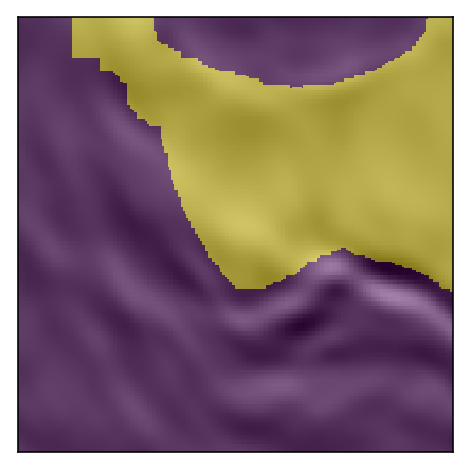

In [133]:
ax = show_img(scale_min(open_image(PATH/test_df.iloc[4]['im_path']), 256))
show_img(tst_preds[4]>avg_best_thresh, ax=ax, alpha=0.5);

In [134]:
resized_tst_preds = []
for i, im in tqdm_notebook(enumerate(tst_preds),total=18000):
    resized = scale_min(im, 101)
    resized_tst_preds.append(resized)
resized_tst_preds = np.array(resized_tst_preds)

In [135]:
resized_tst_preds.shape

(18000, 101, 101)

In [136]:
resized_tst_preds[4]

array([[-0.16541, -0.14488, -0.14191, ...,  0.72816,  0.79733,  0.81277],
       [-0.16245, -0.14023, -0.13772, ...,  0.82972,  0.88362,  0.8954 ],
       [-0.17082, -0.1502 , -0.14605, ...,  0.88901,  0.93309,  0.94462],
       ...,
       [-1.17912, -1.18027, -1.17674, ..., -1.35921, -1.35004, -1.33572],
       [-1.17645, -1.17905, -1.17946, ..., -1.34973, -1.34434, -1.32937],
       [-1.17747, -1.18469, -1.18692, ..., -1.35841, -1.34927, -1.32755]])

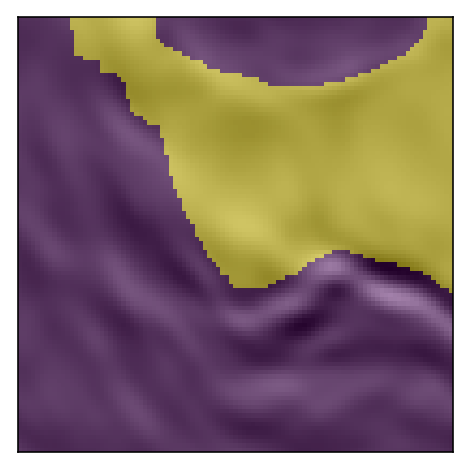

In [137]:
ax = show_img(open_image(PATH/test_df.iloc[4]['im_path']))
show_img(resized_tst_preds[4]>avg_best_thresh, ax=ax, alpha=0.5);

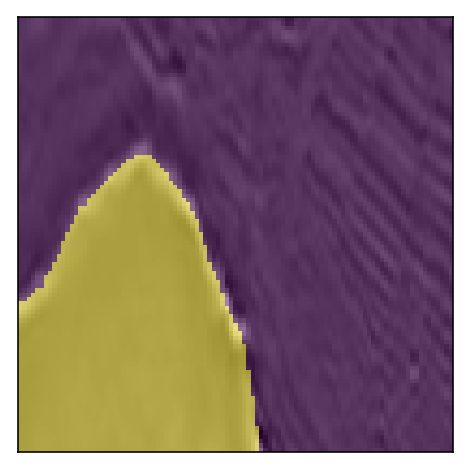

In [138]:
ax = show_img(open_image(PATH/test_df.iloc[17981]['im_path']))
show_img(resized_tst_preds[17981]>avg_best_thresh, ax=ax, alpha=0.5);

In [139]:
# Courtesy of Tadeusz Hupało
# https://www.kaggle.com/thupalo
def rle(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    rle = ' '.join([str(r) for r in run_lengths])
    return rle

In [140]:
rle(resized_tst_preds[4]>avg_best_thresh)

'1213 3 1314 9 1415 9 1516 10 1617 10 1718 10 1819 10 1920 13 2021 13 2122 13 2223 13 2324 14 2425 15 2526 19 2627 22 2728 23 2829 23 2930 24 3031 25 3132 25 3238 20 3340 22 3442 25 3543 30 3645 32 3746 34 3848 36 3949 38 4051 38 4152 41 4253 42 4355 43 4457 44 4558 45 4659 46 4761 47 4862 47 4963 49 5064 50 5165 50 5267 49 5368 49 5469 49 5570 49 5672 48 5773 48 5875 46 5976 46 6077 45 6178 45 6279 44 6380 44 6481 44 6582 43 6683 42 6784 41 6885 41 6986 40 7087 40 7187 40 7288 40 7389 39 7490 39 7591 39 7691 40 7792 41 7893 41 7993 42 8094 43 8195 43 8295 44 8396 45 8496 46 8597 46 8697 47 8798 47 8898 49 8999 49 9099 50 9199 52 9299 53 9399 54 9498 57 9596 60 9697 61 9798 62 9899 63 10000 63 10101 64'

In [141]:
df = pd.DataFrame(test_df.index)

In [142]:
rles = []

for i,im in tqdm_notebook(enumerate(resized_tst_preds),total=18000): rles.append(rle(im>avg_best_thresh))

In [143]:
df['rle_mask'] = rles

In [144]:
df

,id,rle_mask
0,353e010b7b,
1,5439dbbddf,
2,71bab9f311,
3,52551f7a80,
4,512d8d9997,1213 3 1314 9 1415 9 1516 10 1617 10 1718 10 1...
5,64dba827d6,
6,0a3a8a5f37,
7,329563756f,1 706 708 100 809 100 910 100 1011 100 1112 10...
8,f6cba2e890,3839 12 3902 3 3915 38 4003 4 4015 40 4066 2 4...
9,989c646373,


In [145]:
dur = time.time() - pipeline_strt
hrs = dur//3600
mins = (dur-hrs*3600)//60
sec = round((dur-hrs*3600-mins*60))
print(f'5-Fold Train Predict Pipeline Completed in {hrs} hrs {mins} mins {sec} sec')  # Total training/pred duration

5-Fold Train Predict Pipeline Completed in 18.0 hrs 4.0 mins 24 sec


### Make Submission

In [146]:
SUBM = Path('subm/')
os.makedirs(SUBM, exist_ok=True)

In [147]:
fn = 'subm6_unet_resnet34_8fold_3run_best10_snapshots'

In [148]:
df.to_csv(SUBM/f'{fn}.gz', compression='gzip', index=False)

In [149]:
FileLink(SUBM/f'{fn}.gz')

/home/paperspace/fastai/kaggle_tgs_salt_identification_challenge_competition/subm/subm6_unet_resnet34_8fold_3run_best10_snapshots.gz